In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import joblib

import category_encoders as ce
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-linear-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-linear-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-linear-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
numeric_feats = list(input_feats)
len(input_feats)

1308

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting':'dart',
    'linear_tree':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 3000,
    'linear_lambda':10,
    #'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    scalers = list()
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
        
        scaler = StandardScaler(with_mean=True, with_std=True)
        scaler.fit(train_df[numeric_feats].values)
        train_df[numeric_feats] = scaler.transform(train_df[numeric_feats].values)
        valid_df[numeric_feats] = scaler.transform(valid_df[numeric_feats].values)
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=4000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        scalers.append(scaler)
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return scalers,models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758839	valid_0's recall_at4: 0.613103	valid_0's norm_gini: 0.904575


[100]	valid_0's amex_metric: 0.767237	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.909042


[150]	valid_0's amex_metric: 0.770922	valid_0's recall_at4: 0.630523	valid_0's norm_gini: 0.911322


[200]	valid_0's amex_metric: 0.773628	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.912567


[250]	valid_0's amex_metric: 0.777111	valid_0's recall_at4: 0.63978	valid_0's norm_gini: 0.914443


[300]	valid_0's amex_metric: 0.779236	valid_0's recall_at4: 0.642641	valid_0's norm_gini: 0.915832


[350]	valid_0's amex_metric: 0.781428	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.916849


[400]	valid_0's amex_metric: 0.781988	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.917507


[450]	valid_0's amex_metric: 0.784837	valid_0's recall_at4: 0.651014	valid_0's norm_gini: 0.918659


[500]	valid_0's amex_metric: 0.787373	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.919693


[550]	valid_0's amex_metric: 0.788465	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.920783


[600]	valid_0's amex_metric: 0.790774	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.921572


[650]	valid_0's amex_metric: 0.791356	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.921937


[700]	valid_0's amex_metric: 0.792576	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.922356


[750]	valid_0's amex_metric: 0.792566	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922673


[800]	valid_0's amex_metric: 0.793236	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923087


[850]	valid_0's amex_metric: 0.793793	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.923359


[900]	valid_0's amex_metric: 0.794532	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.92366


[950]	valid_0's amex_metric: 0.79457	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923989


[1000]	valid_0's amex_metric: 0.794927	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924238


[1050]	valid_0's amex_metric: 0.795484	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924555


[1100]	valid_0's amex_metric: 0.795699	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924774


[1150]	valid_0's amex_metric: 0.796636	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.92488


[1200]	valid_0's amex_metric: 0.796696	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925


[1250]	valid_0's amex_metric: 0.797179	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925167


[1300]	valid_0's amex_metric: 0.797239	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925203


[1350]	valid_0's amex_metric: 0.797377	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.92531


[1400]	valid_0's amex_metric: 0.797562	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925428


[1450]	valid_0's amex_metric: 0.797449	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925539


[1500]	valid_0's amex_metric: 0.798025	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925595


[1550]	valid_0's amex_metric: 0.7984	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.9258


[1600]	valid_0's amex_metric: 0.797833	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925928


[1650]	valid_0's amex_metric: 0.798265	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925993


[1700]	valid_0's amex_metric: 0.798465	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926014


[1750]	valid_0's amex_metric: 0.798914	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926069


[1800]	valid_0's amex_metric: 0.798983	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926167


[1850]	valid_0's amex_metric: 0.798704	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926198


[1900]	valid_0's amex_metric: 0.798809	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926239


[1950]	valid_0's amex_metric: 0.799032	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926264


[2000]	valid_0's amex_metric: 0.799259	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926296


[2050]	valid_0's amex_metric: 0.799843	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.92633


[2100]	valid_0's amex_metric: 0.799285	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926391


[2150]	valid_0's amex_metric: 0.799484	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92641


[2200]	valid_0's amex_metric: 0.799547	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.92641


[2250]	valid_0's amex_metric: 0.799375	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926403


[2300]	valid_0's amex_metric: 0.799212	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926413


[2350]	valid_0's amex_metric: 0.799481	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926447


[2400]	valid_0's amex_metric: 0.800079	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926423


[2450]	valid_0's amex_metric: 0.799994	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926463


[2500]	valid_0's amex_metric: 0.799823	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926458


[2550]	valid_0's amex_metric: 0.79997	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926457


[2600]	valid_0's amex_metric: 0.800099	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926462


[2650]	valid_0's amex_metric: 0.80017	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926478


[2700]	valid_0's amex_metric: 0.799562	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926525


[2750]	valid_0's amex_metric: 0.799415	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926525


[2800]	valid_0's amex_metric: 0.799881	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926532


[2850]	valid_0's amex_metric: 0.80025	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926554


[2900]	valid_0's amex_metric: 0.800121	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926591


[2950]	valid_0's amex_metric: 0.800058	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926591


[3000]	valid_0's amex_metric: 0.800462	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.9266


[3050]	valid_0's amex_metric: 0.800213	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926564


[3100]	valid_0's amex_metric: 0.800551	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926526


[3150]	valid_0's amex_metric: 0.799965	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.92649


[3200]	valid_0's amex_metric: 0.799949	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926499


[3250]	valid_0's amex_metric: 0.799993	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926502


[3300]	valid_0's amex_metric: 0.799833	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926477


[3350]	valid_0's amex_metric: 0.79965	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.92649


[3400]	valid_0's amex_metric: 0.800087	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.92648


[3450]	valid_0's amex_metric: 0.799973	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926463


[3500]	valid_0's amex_metric: 0.799501	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926444


[3550]	valid_0's amex_metric: 0.799423	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926415


[3600]	valid_0's amex_metric: 0.799407	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926426


[3650]	valid_0's amex_metric: 0.799368	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926388


[3700]	valid_0's amex_metric: 0.799066	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926416


[3750]	valid_0's amex_metric: 0.798628	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926339


[3800]	valid_0's amex_metric: 0.798622	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926328


[3850]	valid_0's amex_metric: 0.799038	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926361


[3900]	valid_0's amex_metric: 0.798734	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926341


[3950]	valid_0's amex_metric: 0.79922	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926346


[4000]	valid_0's amex_metric: 0.798628	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.92634


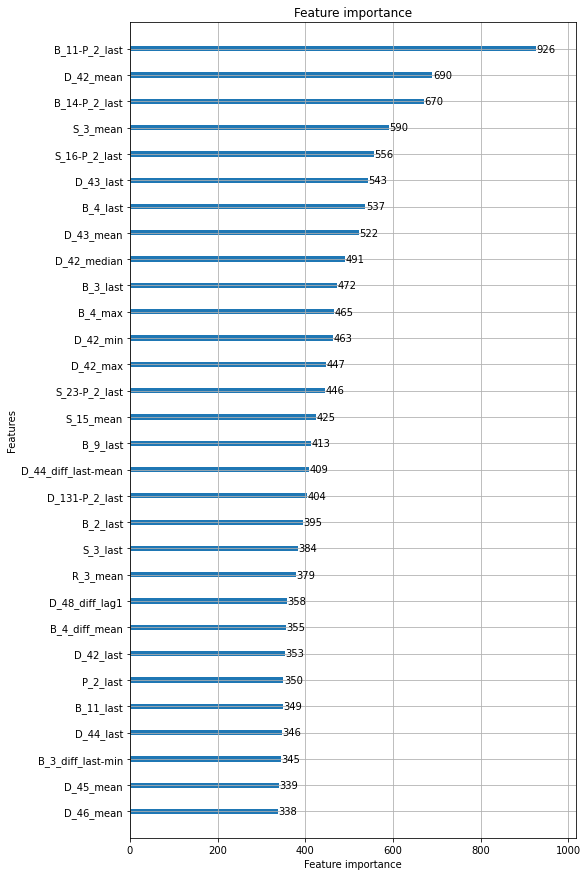

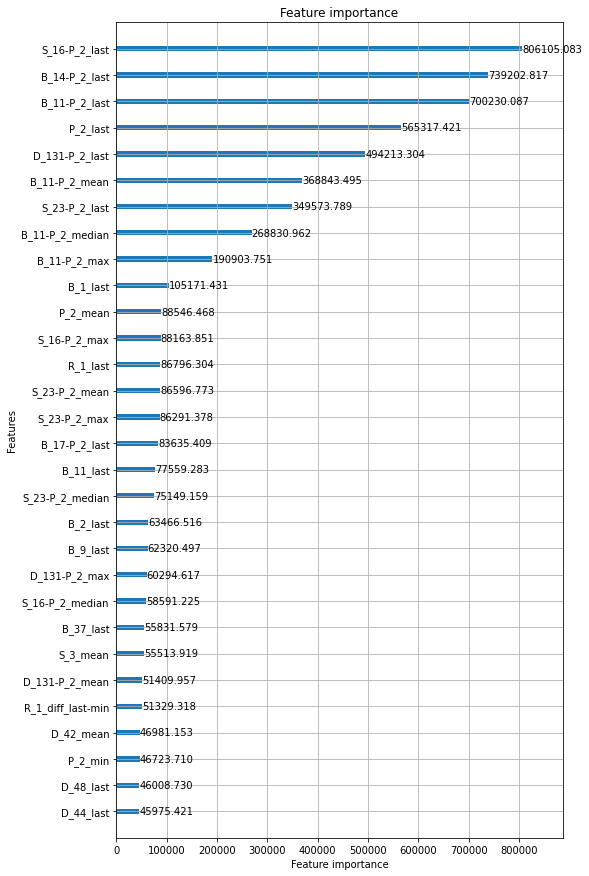

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.757061	valid_0's recall_at4: 0.610494	valid_0's norm_gini: 0.903628


[100]	valid_0's amex_metric: 0.764666	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.908109


[150]	valid_0's amex_metric: 0.768712	valid_0's recall_at4: 0.627156	valid_0's norm_gini: 0.910267


[200]	valid_0's amex_metric: 0.769998	valid_0's recall_at4: 0.628503	valid_0's norm_gini: 0.911493


[250]	valid_0's amex_metric: 0.774624	valid_0's recall_at4: 0.635908	valid_0's norm_gini: 0.913339


[300]	valid_0's amex_metric: 0.776249	valid_0's recall_at4: 0.637634	valid_0's norm_gini: 0.914863


[350]	valid_0's amex_metric: 0.778264	valid_0's recall_at4: 0.640916	valid_0's norm_gini: 0.915612


[400]	valid_0's amex_metric: 0.778409	valid_0's recall_at4: 0.640537	valid_0's norm_gini: 0.916282


[450]	valid_0's amex_metric: 0.781217	valid_0's recall_at4: 0.645123	valid_0's norm_gini: 0.91731


[500]	valid_0's amex_metric: 0.783866	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.918444


[550]	valid_0's amex_metric: 0.786197	valid_0's recall_at4: 0.65295	valid_0's norm_gini: 0.919444


[600]	valid_0's amex_metric: 0.789311	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.920286


[650]	valid_0's amex_metric: 0.789422	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.92076


[700]	valid_0's amex_metric: 0.789865	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921183


[750]	valid_0's amex_metric: 0.790499	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.921527


[800]	valid_0's amex_metric: 0.791632	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.921858


[850]	valid_0's amex_metric: 0.792326	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922194


[900]	valid_0's amex_metric: 0.792284	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.922445


[950]	valid_0's amex_metric: 0.792484	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.922761


[1000]	valid_0's amex_metric: 0.793196	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923008


[1050]	valid_0's amex_metric: 0.793536	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.923393


[1100]	valid_0's amex_metric: 0.7944	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.923606


[1150]	valid_0's amex_metric: 0.794459	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923767


[1200]	valid_0's amex_metric: 0.794733	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.923892


[1250]	valid_0's amex_metric: 0.794713	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924065


[1300]	valid_0's amex_metric: 0.795624	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924119


[1350]	valid_0's amex_metric: 0.795905	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924218


[1400]	valid_0's amex_metric: 0.796172	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924373


[1450]	valid_0's amex_metric: 0.795946	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.92451


[1500]	valid_0's amex_metric: 0.7961	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924609


[1550]	valid_0's amex_metric: 0.796793	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.924731


[1600]	valid_0's amex_metric: 0.797356	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.924847


[1650]	valid_0's amex_metric: 0.79743	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.924869


[1700]	valid_0's amex_metric: 0.797681	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924951


[1750]	valid_0's amex_metric: 0.797723	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.924993


[1800]	valid_0's amex_metric: 0.79755	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925068


[1850]	valid_0's amex_metric: 0.797391	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925127


[1900]	valid_0's amex_metric: 0.797253	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925146


[1950]	valid_0's amex_metric: 0.797324	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925205


[2000]	valid_0's amex_metric: 0.796818	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925286


[2050]	valid_0's amex_metric: 0.797365	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925371


[2100]	valid_0's amex_metric: 0.797829	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925541


[2150]	valid_0's amex_metric: 0.797788	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925627


[2200]	valid_0's amex_metric: 0.797836	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925639


[2250]	valid_0's amex_metric: 0.798318	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925635


[2300]	valid_0's amex_metric: 0.79867	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925624


[2350]	valid_0's amex_metric: 0.798467	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925638


[2400]	valid_0's amex_metric: 0.797835	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.92568


[2450]	valid_0's amex_metric: 0.798398	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925711


[2500]	valid_0's amex_metric: 0.798558	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925737


[2550]	valid_0's amex_metric: 0.798827	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925728


[2600]	valid_0's amex_metric: 0.798997	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925773


[2650]	valid_0's amex_metric: 0.799841	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.925821


[2700]	valid_0's amex_metric: 0.799628	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925857


[2750]	valid_0's amex_metric: 0.799855	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92589


[2800]	valid_0's amex_metric: 0.800214	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.925893


[2850]	valid_0's amex_metric: 0.799766	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.925922


[2900]	valid_0's amex_metric: 0.800077	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925914


[2950]	valid_0's amex_metric: 0.800527	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.925972


[3000]	valid_0's amex_metric: 0.800364	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.925983


[3050]	valid_0's amex_metric: 0.800526	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.926012


[3100]	valid_0's amex_metric: 0.80042	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.925927


[3150]	valid_0's amex_metric: 0.801214	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.926


[3200]	valid_0's amex_metric: 0.80135	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.926018


[3250]	valid_0's amex_metric: 0.801152	valid_0's recall_at4: 0.676302	valid_0's norm_gini: 0.926001


[3300]	valid_0's amex_metric: 0.801112	valid_0's recall_at4: 0.676218	valid_0's norm_gini: 0.926005


[3350]	valid_0's amex_metric: 0.801199	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.926012


[3400]	valid_0's amex_metric: 0.80097	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926017


[3450]	valid_0's amex_metric: 0.801183	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.925981


[3500]	valid_0's amex_metric: 0.801177	valid_0's recall_at4: 0.676344	valid_0's norm_gini: 0.926011


[3550]	valid_0's amex_metric: 0.801093	valid_0's recall_at4: 0.676134	valid_0's norm_gini: 0.926051


[3600]	valid_0's amex_metric: 0.801136	valid_0's recall_at4: 0.676218	valid_0's norm_gini: 0.926053


[3650]	valid_0's amex_metric: 0.800636	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.926021


[3700]	valid_0's amex_metric: 0.80041	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926032


[3750]	valid_0's amex_metric: 0.800388	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.92603


[3800]	valid_0's amex_metric: 0.800293	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926008


[3850]	valid_0's amex_metric: 0.800404	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926021


[3900]	valid_0's amex_metric: 0.800699	valid_0's recall_at4: 0.675377	valid_0's norm_gini: 0.926022


[3950]	valid_0's amex_metric: 0.800374	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926003


[4000]	valid_0's amex_metric: 0.800503	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.926007


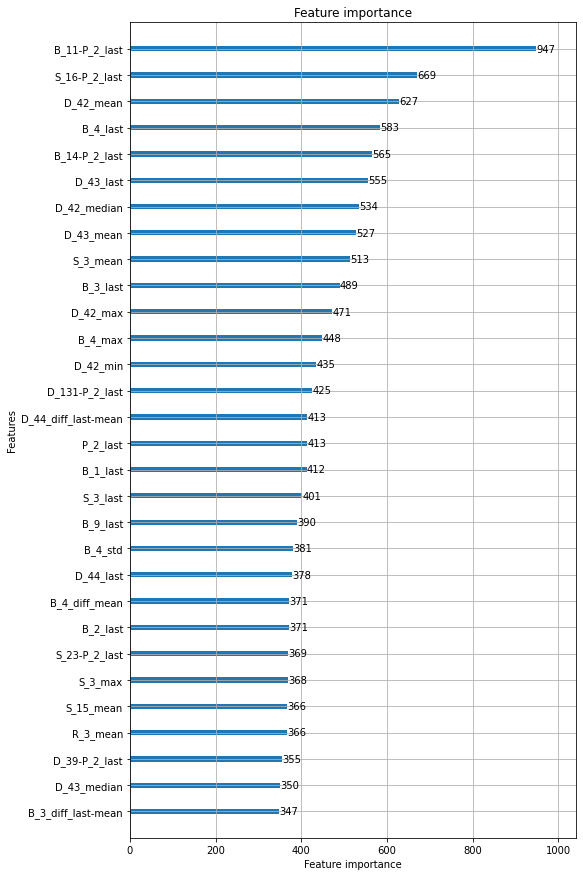

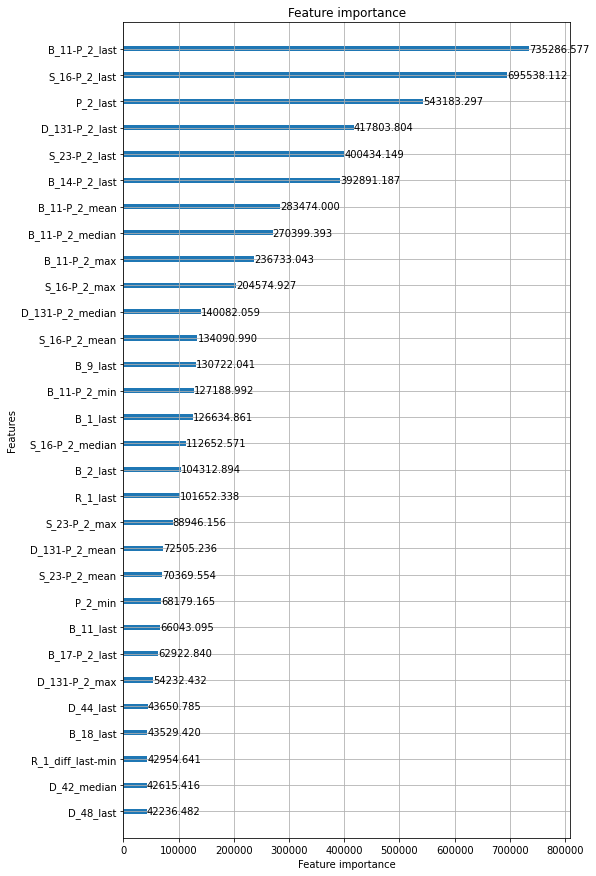

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.75278	valid_0's recall_at4: 0.602962	valid_0's norm_gini: 0.902598


[100]	valid_0's amex_metric: 0.759648	valid_0's recall_at4: 0.612429	valid_0's norm_gini: 0.906866


[150]	valid_0's amex_metric: 0.763314	valid_0's recall_at4: 0.617521	valid_0's norm_gini: 0.909106


[200]	valid_0's amex_metric: 0.765597	valid_0's recall_at4: 0.620634	valid_0's norm_gini: 0.91056


[250]	valid_0's amex_metric: 0.769901	valid_0's recall_at4: 0.627535	valid_0's norm_gini: 0.912267


[300]	valid_0's amex_metric: 0.772842	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.91352


[350]	valid_0's amex_metric: 0.773419	valid_0's recall_at4: 0.632374	valid_0's norm_gini: 0.914465


[400]	valid_0's amex_metric: 0.775252	valid_0's recall_at4: 0.635361	valid_0's norm_gini: 0.915143


[450]	valid_0's amex_metric: 0.776964	valid_0's recall_at4: 0.637718	valid_0's norm_gini: 0.916211


[500]	valid_0's amex_metric: 0.779774	valid_0's recall_at4: 0.642262	valid_0's norm_gini: 0.917286


[550]	valid_0's amex_metric: 0.781363	valid_0's recall_at4: 0.644492	valid_0's norm_gini: 0.918234


[600]	valid_0's amex_metric: 0.784239	valid_0's recall_at4: 0.649373	valid_0's norm_gini: 0.919105


[650]	valid_0's amex_metric: 0.784974	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.919524


[700]	valid_0's amex_metric: 0.786226	valid_0's recall_at4: 0.652529	valid_0's norm_gini: 0.919923


[750]	valid_0's amex_metric: 0.786433	valid_0's recall_at4: 0.652613	valid_0's norm_gini: 0.920254


[800]	valid_0's amex_metric: 0.786896	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.92059


[850]	valid_0's amex_metric: 0.788152	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.920914


[900]	valid_0's amex_metric: 0.788192	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.921246


[950]	valid_0's amex_metric: 0.788591	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.92154


[1000]	valid_0's amex_metric: 0.788832	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.921812


[1050]	valid_0's amex_metric: 0.789892	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922164


[1100]	valid_0's amex_metric: 0.790042	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.922381


[1150]	valid_0's amex_metric: 0.790583	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.922535


[1200]	valid_0's amex_metric: 0.791608	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.922692


[1250]	valid_0's amex_metric: 0.791372	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.922852


[1300]	valid_0's amex_metric: 0.791082	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.922903


[1350]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923


[1400]	valid_0's amex_metric: 0.791884	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923118


[1450]	valid_0's amex_metric: 0.792468	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.923277


[1500]	valid_0's amex_metric: 0.792242	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.923371


[1550]	valid_0's amex_metric: 0.79347	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923554


[1600]	valid_0's amex_metric: 0.793422	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923627


[1650]	valid_0's amex_metric: 0.793296	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.923671


[1700]	valid_0's amex_metric: 0.793759	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923755


[1750]	valid_0's amex_metric: 0.793478	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923823


[1800]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.923835


[1850]	valid_0's amex_metric: 0.79327	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923912


[1900]	valid_0's amex_metric: 0.793548	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923964


[1950]	valid_0's amex_metric: 0.793326	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924025


[2000]	valid_0's amex_metric: 0.793591	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924092


[2050]	valid_0's amex_metric: 0.794032	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924133


[2100]	valid_0's amex_metric: 0.793749	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924198


[2150]	valid_0's amex_metric: 0.794077	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924223


[2200]	valid_0's amex_metric: 0.793586	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.92425


[2250]	valid_0's amex_metric: 0.793345	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924314


[2300]	valid_0's amex_metric: 0.793751	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.924328


[2350]	valid_0's amex_metric: 0.793506	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924342


[2400]	valid_0's amex_metric: 0.793431	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924362


[2450]	valid_0's amex_metric: 0.793675	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924386


[2500]	valid_0's amex_metric: 0.793623	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924365


[2550]	valid_0's amex_metric: 0.79379	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.924364


[2600]	valid_0's amex_metric: 0.794138	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924387


[2650]	valid_0's amex_metric: 0.793969	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924385


[2700]	valid_0's amex_metric: 0.793928	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924387


[2750]	valid_0's amex_metric: 0.794386	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924419


[2800]	valid_0's amex_metric: 0.794288	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924435


[2850]	valid_0's amex_metric: 0.793848	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924437


[2900]	valid_0's amex_metric: 0.793221	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924446


[2950]	valid_0's amex_metric: 0.793266	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924409


[3000]	valid_0's amex_metric: 0.793913	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.924442


[3050]	valid_0's amex_metric: 0.794151	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924454


[3100]	valid_0's amex_metric: 0.794317	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924408


[3150]	valid_0's amex_metric: 0.794436	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924436


[3200]	valid_0's amex_metric: 0.794226	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924436


[3250]	valid_0's amex_metric: 0.794243	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92447


[3300]	valid_0's amex_metric: 0.794566	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924484


[3350]	valid_0's amex_metric: 0.79445	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924464


[3400]	valid_0's amex_metric: 0.794275	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.92445


[3450]	valid_0's amex_metric: 0.794327	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924469


[3500]	valid_0's amex_metric: 0.794271	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.924483


[3550]	valid_0's amex_metric: 0.794005	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924499


[3600]	valid_0's amex_metric: 0.794137	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924511


[3650]	valid_0's amex_metric: 0.793912	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924523


[3700]	valid_0's amex_metric: 0.793893	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924486


[3750]	valid_0's amex_metric: 0.794062	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924487


[3800]	valid_0's amex_metric: 0.794462	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924487


[3850]	valid_0's amex_metric: 0.794682	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924465


[3900]	valid_0's amex_metric: 0.794366	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924464


[3950]	valid_0's amex_metric: 0.79395	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924474


[4000]	valid_0's amex_metric: 0.794509	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924456


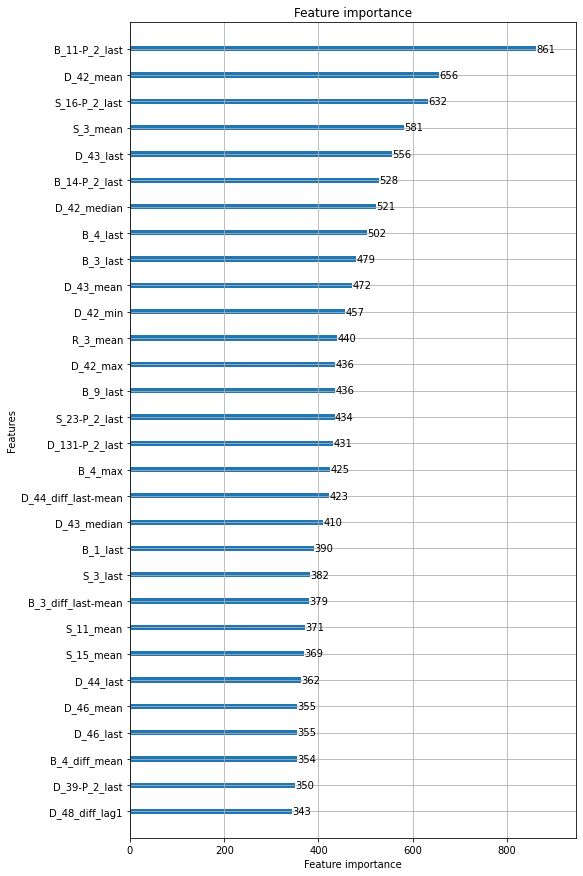

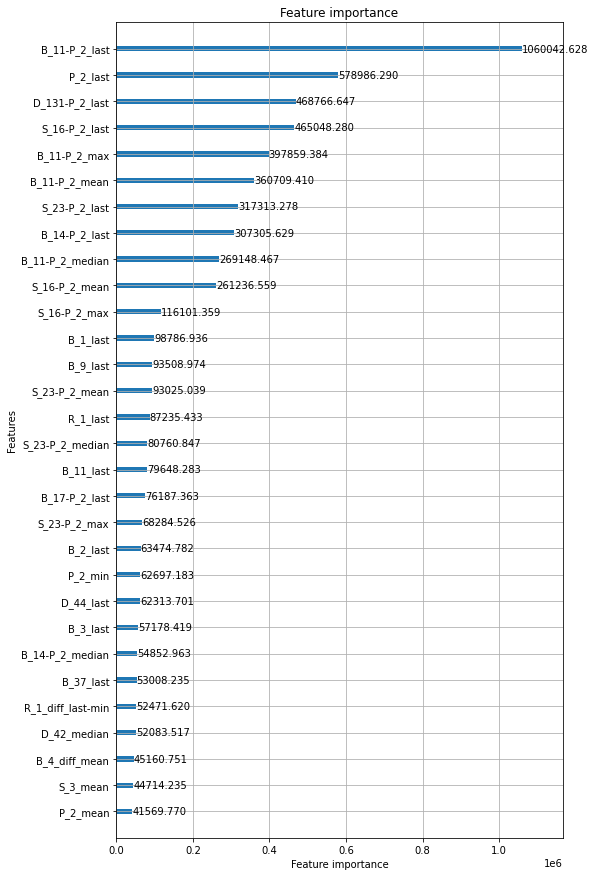

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.752892	valid_0's recall_at4: 0.603787	valid_0's norm_gini: 0.901997


[100]	valid_0's amex_metric: 0.7605	valid_0's recall_at4: 0.614559	valid_0's norm_gini: 0.906441


[150]	valid_0's amex_metric: 0.763764	valid_0's recall_at4: 0.618599	valid_0's norm_gini: 0.908929


[200]	valid_0's amex_metric: 0.766963	valid_0's recall_at4: 0.623522	valid_0's norm_gini: 0.910405


[250]	valid_0's amex_metric: 0.770879	valid_0's recall_at4: 0.629665	valid_0's norm_gini: 0.912093


[300]	valid_0's amex_metric: 0.77305	valid_0's recall_at4: 0.632485	valid_0's norm_gini: 0.913616


[350]	valid_0's amex_metric: 0.774164	valid_0's recall_at4: 0.633873	valid_0's norm_gini: 0.914455


[400]	valid_0's amex_metric: 0.775325	valid_0's recall_at4: 0.635557	valid_0's norm_gini: 0.915094


[450]	valid_0's amex_metric: 0.77693	valid_0's recall_at4: 0.637703	valid_0's norm_gini: 0.916158


[500]	valid_0's amex_metric: 0.779319	valid_0's recall_at4: 0.641195	valid_0's norm_gini: 0.917443


[550]	valid_0's amex_metric: 0.781382	valid_0's recall_at4: 0.644309	valid_0's norm_gini: 0.918456


[600]	valid_0's amex_metric: 0.782494	valid_0's recall_at4: 0.645655	valid_0's norm_gini: 0.919333


[650]	valid_0's amex_metric: 0.783426	valid_0's recall_at4: 0.647086	valid_0's norm_gini: 0.919767


[700]	valid_0's amex_metric: 0.784691	valid_0's recall_at4: 0.649148	valid_0's norm_gini: 0.920234


[750]	valid_0's amex_metric: 0.785043	valid_0's recall_at4: 0.649569	valid_0's norm_gini: 0.920518


[800]	valid_0's amex_metric: 0.785714	valid_0's recall_at4: 0.650579	valid_0's norm_gini: 0.92085


[850]	valid_0's amex_metric: 0.785613	valid_0's recall_at4: 0.650074	valid_0's norm_gini: 0.921152


[900]	valid_0's amex_metric: 0.786476	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.921406


[950]	valid_0's amex_metric: 0.787239	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.921753


[1000]	valid_0's amex_metric: 0.787992	valid_0's recall_at4: 0.653945	valid_0's norm_gini: 0.92204


[1050]	valid_0's amex_metric: 0.787809	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.922346


[1100]	valid_0's amex_metric: 0.787871	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.922596


[1150]	valid_0's amex_metric: 0.788399	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.922811


[1200]	valid_0's amex_metric: 0.788699	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.922947


[1250]	valid_0's amex_metric: 0.789436	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.923159


[1300]	valid_0's amex_metric: 0.788903	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.923188


[1350]	valid_0's amex_metric: 0.789104	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.923296


[1400]	valid_0's amex_metric: 0.789497	valid_0's recall_at4: 0.655586	valid_0's norm_gini: 0.923407


[1450]	valid_0's amex_metric: 0.78964	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.923526


[1500]	valid_0's amex_metric: 0.789697	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.92364


[1550]	valid_0's amex_metric: 0.789865	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.923765


[1600]	valid_0's amex_metric: 0.790245	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923893


[1650]	valid_0's amex_metric: 0.78995	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.923977


[1700]	valid_0's amex_metric: 0.789938	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.924039


[1750]	valid_0's amex_metric: 0.790521	valid_0's recall_at4: 0.656932	valid_0's norm_gini: 0.92411


[1800]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.924205


[1850]	valid_0's amex_metric: 0.791059	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.924302


[1900]	valid_0's amex_metric: 0.790865	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.924292


[1950]	valid_0's amex_metric: 0.790537	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.924309


[2000]	valid_0's amex_metric: 0.791181	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.92442


[2050]	valid_0's amex_metric: 0.791219	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.924496


[2100]	valid_0's amex_metric: 0.791078	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.92455


[2150]	valid_0's amex_metric: 0.79151	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924614


[2200]	valid_0's amex_metric: 0.791854	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.924671


[2250]	valid_0's amex_metric: 0.791754	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924683


[2300]	valid_0's amex_metric: 0.791549	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924692


[2350]	valid_0's amex_metric: 0.791241	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.924707


[2400]	valid_0's amex_metric: 0.791777	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924728


[2450]	valid_0's amex_metric: 0.791617	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924786


[2500]	valid_0's amex_metric: 0.79182	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924814


[2550]	valid_0's amex_metric: 0.791641	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924834


[2600]	valid_0's amex_metric: 0.791508	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.924821


[2650]	valid_0's amex_metric: 0.792014	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924865


[2700]	valid_0's amex_metric: 0.792022	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924881


[2750]	valid_0's amex_metric: 0.792071	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924895


[2800]	valid_0's amex_metric: 0.791706	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.924881


[2850]	valid_0's amex_metric: 0.791504	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.924898


[2900]	valid_0's amex_metric: 0.792387	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.924896


[2950]	valid_0's amex_metric: 0.792636	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924889


[3000]	valid_0's amex_metric: 0.791927	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.924859


[3050]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.924859


[3100]	valid_0's amex_metric: 0.792036	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.924868


[3150]	valid_0's amex_metric: 0.791413	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.924884


[3200]	valid_0's amex_metric: 0.792128	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924882


[3250]	valid_0's amex_metric: 0.792007	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924893


[3300]	valid_0's amex_metric: 0.79166	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924915


[3350]	valid_0's amex_metric: 0.792027	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924933


[3400]	valid_0's amex_metric: 0.791451	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.924918


[3450]	valid_0's amex_metric: 0.79143	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.924918


[3500]	valid_0's amex_metric: 0.7924	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.924923


[3550]	valid_0's amex_metric: 0.791774	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.924932


[3600]	valid_0's amex_metric: 0.792024	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924927


[3650]	valid_0's amex_metric: 0.791688	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924971


[3700]	valid_0's amex_metric: 0.79187	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924955


[3750]	valid_0's amex_metric: 0.792043	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924965


[3800]	valid_0's amex_metric: 0.792786	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924936


[3850]	valid_0's amex_metric: 0.792727	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924945


[3900]	valid_0's amex_metric: 0.79304	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.924941


[3950]	valid_0's amex_metric: 0.79323	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.92494


[4000]	valid_0's amex_metric: 0.792875	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924946


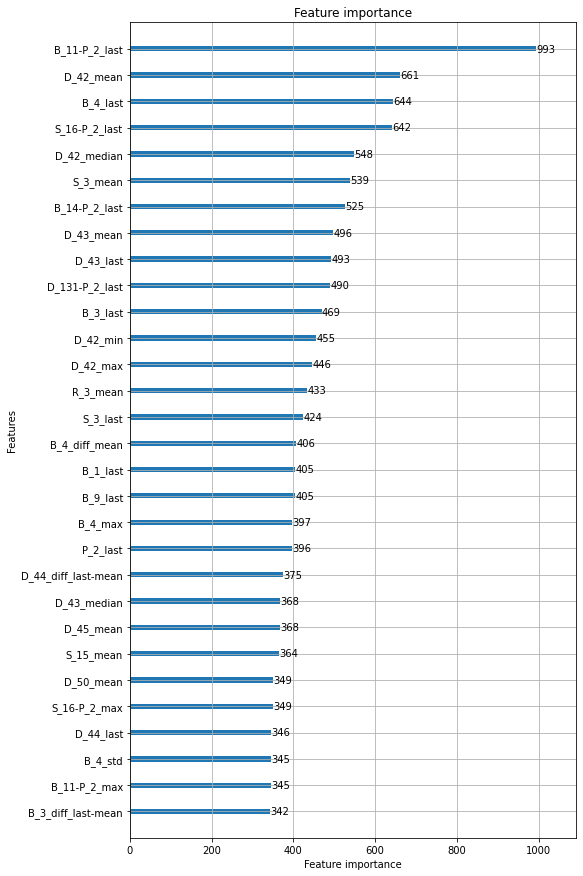

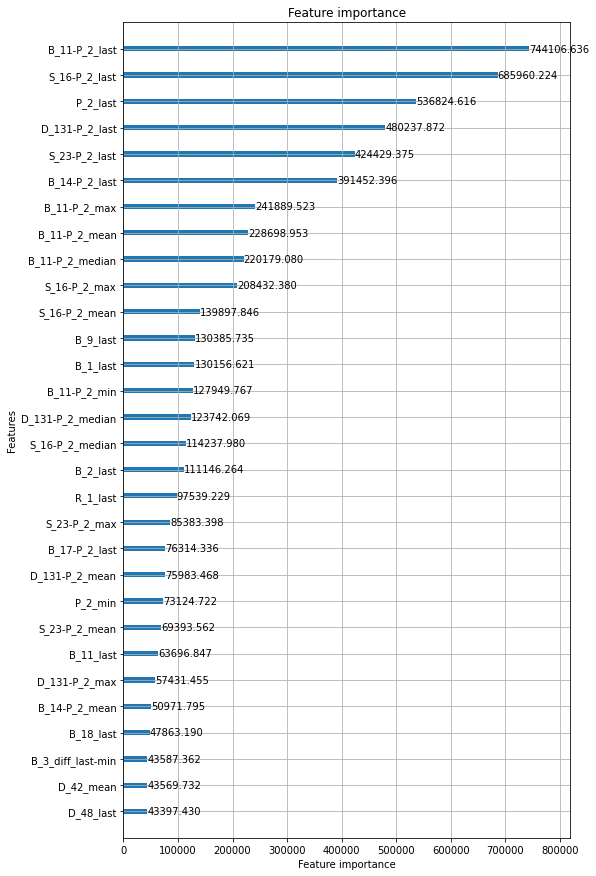

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.762206	valid_0's recall_at4: 0.618515	valid_0's norm_gini: 0.905898


[100]	valid_0's amex_metric: 0.771276	valid_0's recall_at4: 0.63219	valid_0's norm_gini: 0.910362


[150]	valid_0's amex_metric: 0.775302	valid_0's recall_at4: 0.637829	valid_0's norm_gini: 0.912775


[200]	valid_0's amex_metric: 0.775948	valid_0's recall_at4: 0.637871	valid_0's norm_gini: 0.914025


[250]	valid_0's amex_metric: 0.780009	valid_0's recall_at4: 0.644183	valid_0's norm_gini: 0.915836


[300]	valid_0's amex_metric: 0.782754	valid_0's recall_at4: 0.648306	valid_0's norm_gini: 0.917201


[350]	valid_0's amex_metric: 0.783463	valid_0's recall_at4: 0.648938	valid_0's norm_gini: 0.917988


[400]	valid_0's amex_metric: 0.785078	valid_0's recall_at4: 0.65142	valid_0's norm_gini: 0.918736


[450]	valid_0's amex_metric: 0.786817	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.919772


[500]	valid_0's amex_metric: 0.788178	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.920895


[550]	valid_0's amex_metric: 0.790689	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.921962


[600]	valid_0's amex_metric: 0.792556	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.922752


[650]	valid_0's amex_metric: 0.792866	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.923119


[700]	valid_0's amex_metric: 0.794045	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.923668


[750]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.923934


[800]	valid_0's amex_metric: 0.795066	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924279


[850]	valid_0's amex_metric: 0.796048	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.924601


[900]	valid_0's amex_metric: 0.796381	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.924932


[950]	valid_0's amex_metric: 0.796156	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.925155


[1000]	valid_0's amex_metric: 0.796753	valid_0's recall_at4: 0.668041	valid_0's norm_gini: 0.925465


[1050]	valid_0's amex_metric: 0.797972	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925798


[1100]	valid_0's amex_metric: 0.797599	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925978


[1150]	valid_0's amex_metric: 0.798225	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.926136


[1200]	valid_0's amex_metric: 0.798259	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.926205


[1250]	valid_0's amex_metric: 0.79806	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.926354


[1300]	valid_0's amex_metric: 0.79865	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926396


[1350]	valid_0's amex_metric: 0.798981	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.92647


[1400]	valid_0's amex_metric: 0.799603	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.92662


[1450]	valid_0's amex_metric: 0.800151	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.926748


[1500]	valid_0's amex_metric: 0.800128	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.92683


[1550]	valid_0's amex_metric: 0.799904	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.92697


[1600]	valid_0's amex_metric: 0.800493	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.927095


[1650]	valid_0's amex_metric: 0.800311	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.927194


[1700]	valid_0's amex_metric: 0.80084	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.927244


[1750]	valid_0's amex_metric: 0.801666	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.927339


[1800]	valid_0's amex_metric: 0.801979	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927416


[1850]	valid_0's amex_metric: 0.802531	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.92747


[1900]	valid_0's amex_metric: 0.802144	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927494


[1950]	valid_0's amex_metric: 0.802238	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927515


[2000]	valid_0's amex_metric: 0.802654	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927589


[2050]	valid_0's amex_metric: 0.803167	valid_0's recall_at4: 0.678645	valid_0's norm_gini: 0.927688


[2100]	valid_0's amex_metric: 0.803127	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927777


[2150]	valid_0's amex_metric: 0.803027	valid_0's recall_at4: 0.678266	valid_0's norm_gini: 0.927789


[2200]	valid_0's amex_metric: 0.803623	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.927844


[2250]	valid_0's amex_metric: 0.803279	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.927871


[2300]	valid_0's amex_metric: 0.803711	valid_0's recall_at4: 0.679571	valid_0's norm_gini: 0.927851


[2350]	valid_0's amex_metric: 0.803995	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.927872


[2400]	valid_0's amex_metric: 0.804179	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.927903


[2450]	valid_0's amex_metric: 0.803814	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.927889


[2500]	valid_0's amex_metric: 0.804593	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.927933


[2550]	valid_0's amex_metric: 0.804322	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.92798


[2600]	valid_0's amex_metric: 0.804067	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.928016


[2650]	valid_0's amex_metric: 0.804617	valid_0's recall_at4: 0.681212	valid_0's norm_gini: 0.928022


[2700]	valid_0's amex_metric: 0.804647	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928039


[2750]	valid_0's amex_metric: 0.804955	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.928067


[2800]	valid_0's amex_metric: 0.804794	valid_0's recall_at4: 0.681548	valid_0's norm_gini: 0.928039


[2850]	valid_0's amex_metric: 0.805174	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.928085


[2900]	valid_0's amex_metric: 0.805183	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.928102


[2950]	valid_0's amex_metric: 0.805318	valid_0's recall_at4: 0.682558	valid_0's norm_gini: 0.928077


[3000]	valid_0's amex_metric: 0.804617	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928106


[3050]	valid_0's amex_metric: 0.80537	valid_0's recall_at4: 0.6826	valid_0's norm_gini: 0.928141


[3100]	valid_0's amex_metric: 0.805578	valid_0's recall_at4: 0.683021	valid_0's norm_gini: 0.928135


[3150]	valid_0's amex_metric: 0.805249	valid_0's recall_at4: 0.682306	valid_0's norm_gini: 0.928192


[3200]	valid_0's amex_metric: 0.804959	valid_0's recall_at4: 0.681717	valid_0's norm_gini: 0.928201


[3250]	valid_0's amex_metric: 0.804675	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928223


[3300]	valid_0's amex_metric: 0.804334	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.928214


[3350]	valid_0's amex_metric: 0.80467	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928212


[3400]	valid_0's amex_metric: 0.80421	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.928219


[3450]	valid_0's amex_metric: 0.804026	valid_0's recall_at4: 0.679823	valid_0's norm_gini: 0.928229


[3500]	valid_0's amex_metric: 0.804266	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.928204


[3550]	valid_0's amex_metric: 0.804521	valid_0's recall_at4: 0.680833	valid_0's norm_gini: 0.928209


[3600]	valid_0's amex_metric: 0.804309	valid_0's recall_at4: 0.680412	valid_0's norm_gini: 0.928205


[3650]	valid_0's amex_metric: 0.804333	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.928211


[3700]	valid_0's amex_metric: 0.804127	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.928178


[3750]	valid_0's amex_metric: 0.804005	valid_0's recall_at4: 0.679823	valid_0's norm_gini: 0.928187


[3800]	valid_0's amex_metric: 0.803629	valid_0's recall_at4: 0.679066	valid_0's norm_gini: 0.928192


[3850]	valid_0's amex_metric: 0.804108	valid_0's recall_at4: 0.680034	valid_0's norm_gini: 0.928182


[3900]	valid_0's amex_metric: 0.804159	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928158


[3950]	valid_0's amex_metric: 0.804044	valid_0's recall_at4: 0.67995	valid_0's norm_gini: 0.928138


[4000]	valid_0's amex_metric: 0.803739	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928159


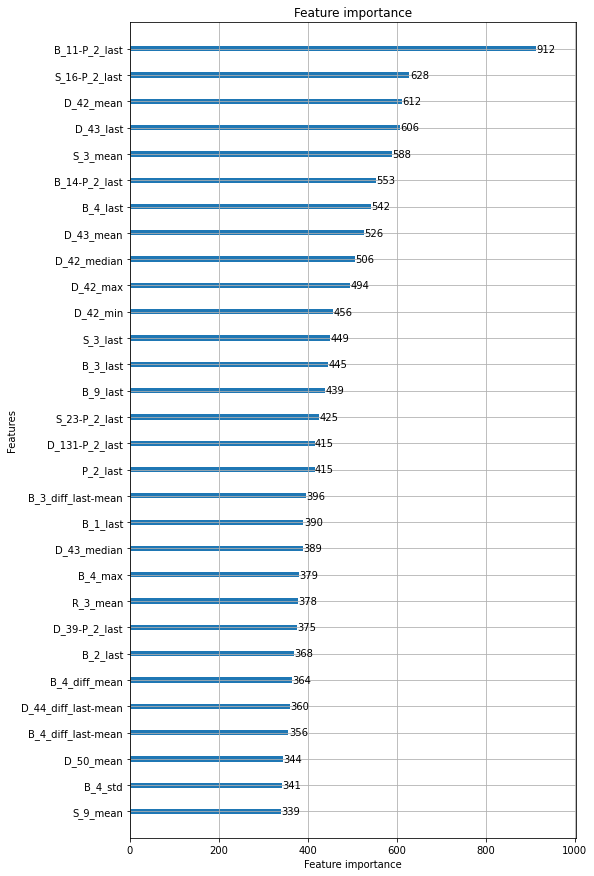

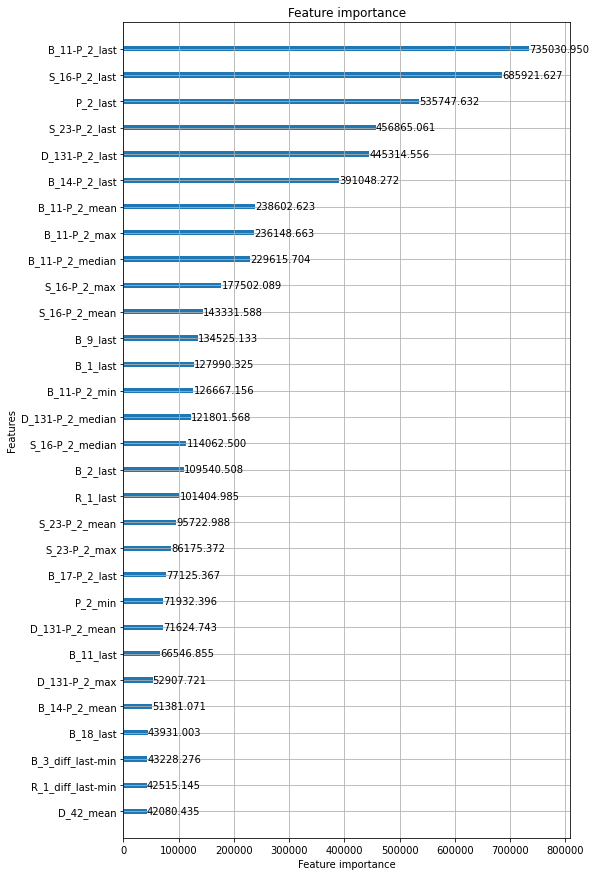

Training time: 216.1935753305753 min.


OOF recall_at4: 0.6699262800013465


OOF normalized_gini: 0.9258506284468399


OOF competition metric: 0.7978884542240932


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758807	valid_0's recall_at4: 0.613271	valid_0's norm_gini: 0.904342


[100]	valid_0's amex_metric: 0.76823	valid_0's recall_at4: 0.627619	valid_0's norm_gini: 0.90884


[150]	valid_0's amex_metric: 0.772473	valid_0's recall_at4: 0.633805	valid_0's norm_gini: 0.911142


[200]	valid_0's amex_metric: 0.774064	valid_0's recall_at4: 0.635572	valid_0's norm_gini: 0.912556


[250]	valid_0's amex_metric: 0.778221	valid_0's recall_at4: 0.642094	valid_0's norm_gini: 0.914348


[300]	valid_0's amex_metric: 0.779686	valid_0's recall_at4: 0.643524	valid_0's norm_gini: 0.915847


[350]	valid_0's amex_metric: 0.781727	valid_0's recall_at4: 0.646764	valid_0's norm_gini: 0.91669


[400]	valid_0's amex_metric: 0.783088	valid_0's recall_at4: 0.648742	valid_0's norm_gini: 0.917435


[450]	valid_0's amex_metric: 0.7848	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.918418


[500]	valid_0's amex_metric: 0.78679	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.919704


[550]	valid_0's amex_metric: 0.789481	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.92071


[600]	valid_0's amex_metric: 0.791057	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.921549


[650]	valid_0's amex_metric: 0.791364	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.921952


[700]	valid_0's amex_metric: 0.791492	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.922502


[750]	valid_0's amex_metric: 0.792151	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922811


[800]	valid_0's amex_metric: 0.793568	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923037


[850]	valid_0's amex_metric: 0.793164	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.923322


[900]	valid_0's amex_metric: 0.794503	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923602


[950]	valid_0's amex_metric: 0.795248	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.923913


[1000]	valid_0's amex_metric: 0.796059	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924189


[1050]	valid_0's amex_metric: 0.79682	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.924532


[1100]	valid_0's amex_metric: 0.796861	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924783


[1150]	valid_0's amex_metric: 0.796483	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.924911


[1200]	valid_0's amex_metric: 0.797474	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925041


[1250]	valid_0's amex_metric: 0.797695	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925189


[1300]	valid_0's amex_metric: 0.798096	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925234


[1350]	valid_0's amex_metric: 0.797694	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925313


[1400]	valid_0's amex_metric: 0.798422	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925464


[1450]	valid_0's amex_metric: 0.798976	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925605


[1500]	valid_0's amex_metric: 0.798924	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.92567


[1550]	valid_0's amex_metric: 0.799193	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925828


[1600]	valid_0's amex_metric: 0.799257	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925957


[1650]	valid_0's amex_metric: 0.799925	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92603


[1700]	valid_0's amex_metric: 0.800459	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.926088


[1750]	valid_0's amex_metric: 0.800348	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926161


[1800]	valid_0's amex_metric: 0.800923	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.926217


[1850]	valid_0's amex_metric: 0.800482	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.926302


[1900]	valid_0's amex_metric: 0.800417	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.9263


[1950]	valid_0's amex_metric: 0.800173	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926316


[2000]	valid_0's amex_metric: 0.800756	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.92643


[2050]	valid_0's amex_metric: 0.80034	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926482


[2100]	valid_0's amex_metric: 0.800021	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926558


[2150]	valid_0's amex_metric: 0.800448	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926656


[2200]	valid_0's amex_metric: 0.800056	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926713


[2250]	valid_0's amex_metric: 0.79998	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926729


[2300]	valid_0's amex_metric: 0.801034	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.926734


[2350]	valid_0's amex_metric: 0.80116	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.926775


[2400]	valid_0's amex_metric: 0.801238	valid_0's recall_at4: 0.675671	valid_0's norm_gini: 0.926805


[2450]	valid_0's amex_metric: 0.801392	valid_0's recall_at4: 0.675966	valid_0's norm_gini: 0.926819


[2500]	valid_0's amex_metric: 0.801593	valid_0's recall_at4: 0.676344	valid_0's norm_gini: 0.926842


[2550]	valid_0's amex_metric: 0.800967	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926853


[2600]	valid_0's amex_metric: 0.80041	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926875


[2650]	valid_0's amex_metric: 0.800464	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926855


[2700]	valid_0's amex_metric: 0.80089	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.926867


[2750]	valid_0's amex_metric: 0.800982	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926882


[2800]	valid_0's amex_metric: 0.800646	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926925


[2850]	valid_0's amex_metric: 0.801282	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.926977


[2900]	valid_0's amex_metric: 0.80023	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926978


[2950]	valid_0's amex_metric: 0.800749	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926962


[3000]	valid_0's amex_metric: 0.800933	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926994


[3050]	valid_0's amex_metric: 0.801084	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.927044


[3100]	valid_0's amex_metric: 0.801244	valid_0's recall_at4: 0.675377	valid_0's norm_gini: 0.927112


[3150]	valid_0's amex_metric: 0.800652	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.927064


[3200]	valid_0's amex_metric: 0.800503	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.927103


[3250]	valid_0's amex_metric: 0.800905	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.927107


[3300]	valid_0's amex_metric: 0.801077	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.927114


[3350]	valid_0's amex_metric: 0.801353	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.927119


[3400]	valid_0's amex_metric: 0.801018	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.927122


[3450]	valid_0's amex_metric: 0.80081	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.927085


[3500]	valid_0's amex_metric: 0.801499	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.927075


[3550]	valid_0's amex_metric: 0.800801	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.927068


[3600]	valid_0's amex_metric: 0.800608	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.927059


[3650]	valid_0's amex_metric: 0.801307	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.927069


[3700]	valid_0's amex_metric: 0.801492	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.927061


[3750]	valid_0's amex_metric: 0.801775	valid_0's recall_at4: 0.676513	valid_0's norm_gini: 0.927037


[3800]	valid_0's amex_metric: 0.801082	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.92704


[3850]	valid_0's amex_metric: 0.801213	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.927007


[3900]	valid_0's amex_metric: 0.801153	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.927014


[3950]	valid_0's amex_metric: 0.801563	valid_0's recall_at4: 0.676092	valid_0's norm_gini: 0.927035


[4000]	valid_0's amex_metric: 0.801479	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.927034


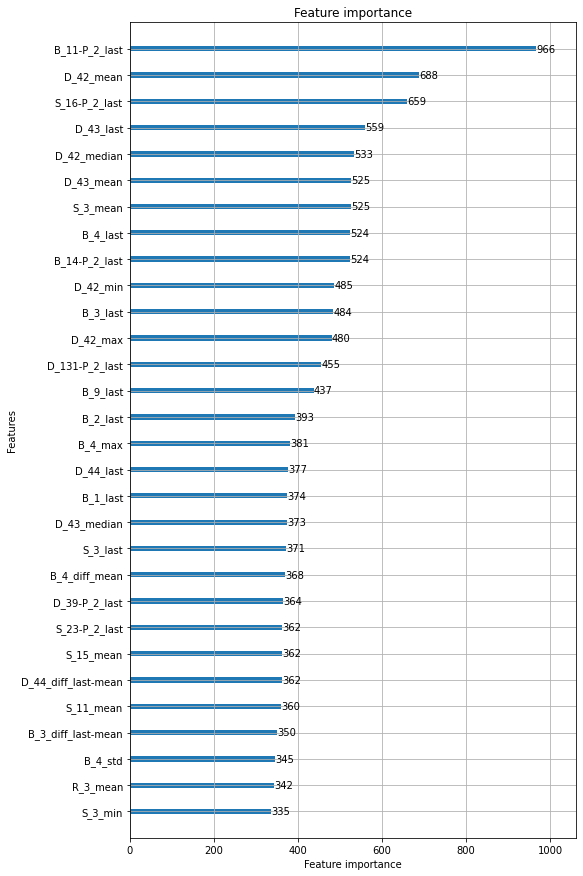

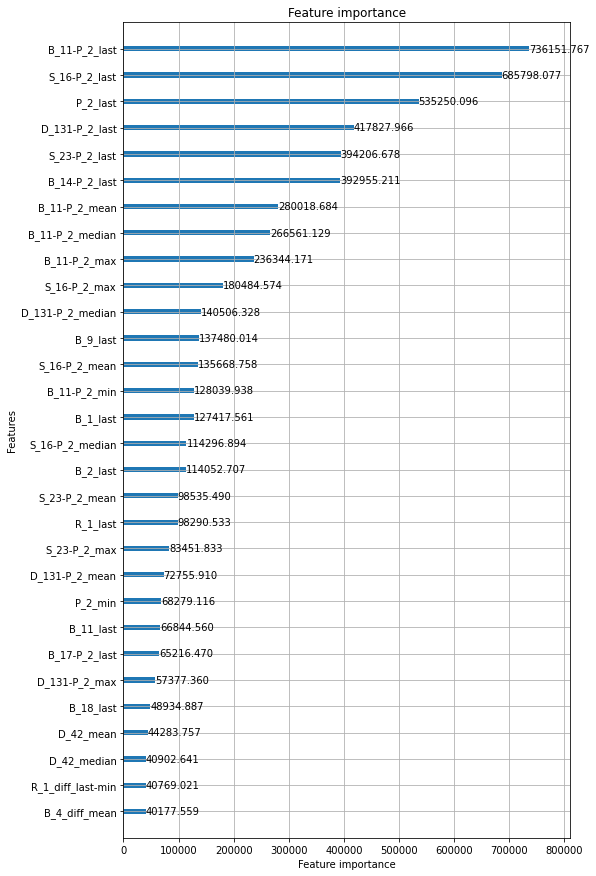

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.755541	valid_0's recall_at4: 0.607843	valid_0's norm_gini: 0.903239


[100]	valid_0's amex_metric: 0.761401	valid_0's recall_at4: 0.61508	valid_0's norm_gini: 0.907721


[150]	valid_0's amex_metric: 0.766955	valid_0's recall_at4: 0.623832	valid_0's norm_gini: 0.910078


[200]	valid_0's amex_metric: 0.768844	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.911416


[250]	valid_0's amex_metric: 0.773142	valid_0's recall_at4: 0.633005	valid_0's norm_gini: 0.913278


[300]	valid_0's amex_metric: 0.774533	valid_0's recall_at4: 0.634394	valid_0's norm_gini: 0.914673


[350]	valid_0's amex_metric: 0.775547	valid_0's recall_at4: 0.635614	valid_0's norm_gini: 0.91548


[400]	valid_0's amex_metric: 0.77758	valid_0's recall_at4: 0.63898	valid_0's norm_gini: 0.91618


[450]	valid_0's amex_metric: 0.779256	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.917301


[500]	valid_0's amex_metric: 0.781365	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.918406


[550]	valid_0's amex_metric: 0.783371	valid_0's recall_at4: 0.647395	valid_0's norm_gini: 0.919346


[600]	valid_0's amex_metric: 0.784578	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.920162


[650]	valid_0's amex_metric: 0.785153	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.920469


[700]	valid_0's amex_metric: 0.786887	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.920992


[750]	valid_0's amex_metric: 0.786826	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.921334


[800]	valid_0's amex_metric: 0.788036	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.92165


[850]	valid_0's amex_metric: 0.788413	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.921942


[900]	valid_0's amex_metric: 0.788689	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.922198


[950]	valid_0's amex_metric: 0.78859	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.922548


[1000]	valid_0's amex_metric: 0.789756	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922776


[1050]	valid_0's amex_metric: 0.791129	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923122


[1100]	valid_0's amex_metric: 0.790791	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923331


[1150]	valid_0's amex_metric: 0.791945	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923535


[1200]	valid_0's amex_metric: 0.792152	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923696


[1250]	valid_0's amex_metric: 0.792505	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.923856


[1300]	valid_0's amex_metric: 0.792574	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923909


[1350]	valid_0's amex_metric: 0.792839	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924019


[1400]	valid_0's amex_metric: 0.792916	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924131


[1450]	valid_0's amex_metric: 0.793102	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924251


[1500]	valid_0's amex_metric: 0.792998	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924336


[1550]	valid_0's amex_metric: 0.793319	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924473


[1600]	valid_0's amex_metric: 0.793849	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924607


[1650]	valid_0's amex_metric: 0.794075	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924723


[1700]	valid_0's amex_metric: 0.794256	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924832


[1750]	valid_0's amex_metric: 0.794581	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924894


[1800]	valid_0's amex_metric: 0.794905	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924995


[1850]	valid_0's amex_metric: 0.795286	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.925042


[1900]	valid_0's amex_metric: 0.79568	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925071


[1950]	valid_0's amex_metric: 0.795584	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.92509


[2000]	valid_0's amex_metric: 0.795476	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925126


[2050]	valid_0's amex_metric: 0.796024	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925214


[2100]	valid_0's amex_metric: 0.796129	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.925254


[2150]	valid_0's amex_metric: 0.796567	valid_0's recall_at4: 0.667845	valid_0's norm_gini: 0.925288


[2200]	valid_0's amex_metric: 0.796323	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925349


[2250]	valid_0's amex_metric: 0.796261	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925349


[2300]	valid_0's amex_metric: 0.796146	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925331


[2350]	valid_0's amex_metric: 0.796029	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.925349


[2400]	valid_0's amex_metric: 0.796469	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925345


[2450]	valid_0's amex_metric: 0.796348	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925356


[2500]	valid_0's amex_metric: 0.796456	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925362


[2550]	valid_0's amex_metric: 0.796291	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925367


[2600]	valid_0's amex_metric: 0.796142	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925364


[2650]	valid_0's amex_metric: 0.796444	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.92538


[2700]	valid_0's amex_metric: 0.796753	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925366


[2750]	valid_0's amex_metric: 0.796786	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.925391


[2800]	valid_0's amex_metric: 0.796192	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.925381


[2850]	valid_0's amex_metric: 0.79615	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925381


[2900]	valid_0's amex_metric: 0.796468	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925386


[2950]	valid_0's amex_metric: 0.796373	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.925364


[3000]	valid_0's amex_metric: 0.796223	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925359


[3050]	valid_0's amex_metric: 0.796457	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925364


[3100]	valid_0's amex_metric: 0.796094	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925396


[3150]	valid_0's amex_metric: 0.796286	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925359


[3200]	valid_0's amex_metric: 0.796626	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.925365


[3250]	valid_0's amex_metric: 0.796649	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.925369


[3300]	valid_0's amex_metric: 0.796336	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925373


[3350]	valid_0's amex_metric: 0.796735	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.925372


[3400]	valid_0's amex_metric: 0.796743	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925347


[3450]	valid_0's amex_metric: 0.796404	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925341


[3500]	valid_0's amex_metric: 0.7967	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925388


[3550]	valid_0's amex_metric: 0.796225	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925363


[3600]	valid_0's amex_metric: 0.796225	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925363


[3650]	valid_0's amex_metric: 0.795646	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925383


[3700]	valid_0's amex_metric: 0.795486	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.9254


[3750]	valid_0's amex_metric: 0.795535	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.925371


[3800]	valid_0's amex_metric: 0.795317	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.925398


[3850]	valid_0's amex_metric: 0.795091	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925408


[3900]	valid_0's amex_metric: 0.794719	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.92538


[3950]	valid_0's amex_metric: 0.794814	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.92536


[4000]	valid_0's amex_metric: 0.795396	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.925346


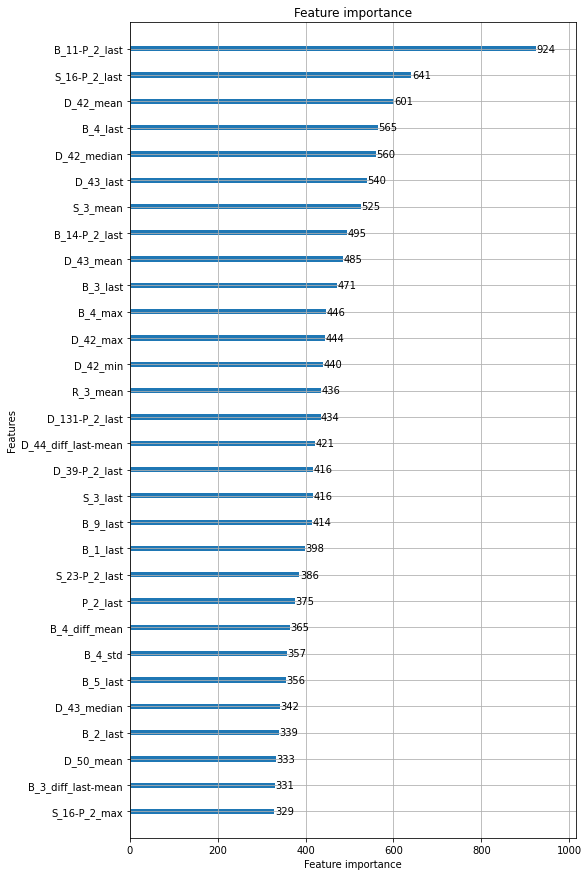

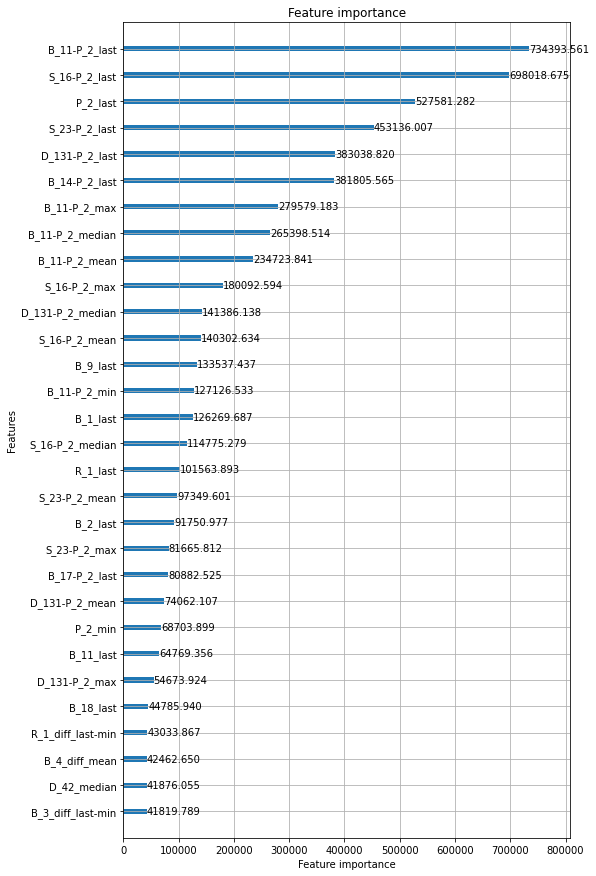

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.753146	valid_0's recall_at4: 0.604351	valid_0's norm_gini: 0.901942


[100]	valid_0's amex_metric: 0.760546	valid_0's recall_at4: 0.615038	valid_0's norm_gini: 0.906054


[150]	valid_0's amex_metric: 0.763586	valid_0's recall_at4: 0.618489	valid_0's norm_gini: 0.908684


[200]	valid_0's amex_metric: 0.76634	valid_0's recall_at4: 0.622486	valid_0's norm_gini: 0.910194


[250]	valid_0's amex_metric: 0.769188	valid_0's recall_at4: 0.626357	valid_0's norm_gini: 0.912019


[300]	valid_0's amex_metric: 0.772574	valid_0's recall_at4: 0.631617	valid_0's norm_gini: 0.913532


[350]	valid_0's amex_metric: 0.773763	valid_0's recall_at4: 0.633131	valid_0's norm_gini: 0.914394


[400]	valid_0's amex_metric: 0.774456	valid_0's recall_at4: 0.633763	valid_0's norm_gini: 0.91515


[450]	valid_0's amex_metric: 0.776347	valid_0's recall_at4: 0.636371	valid_0's norm_gini: 0.916324


[500]	valid_0's amex_metric: 0.778011	valid_0's recall_at4: 0.638517	valid_0's norm_gini: 0.917504


[550]	valid_0's amex_metric: 0.780751	valid_0's recall_at4: 0.642977	valid_0's norm_gini: 0.918524


[600]	valid_0's amex_metric: 0.782759	valid_0's recall_at4: 0.646091	valid_0's norm_gini: 0.919427


[650]	valid_0's amex_metric: 0.783476	valid_0's recall_at4: 0.647059	valid_0's norm_gini: 0.919892


[700]	valid_0's amex_metric: 0.784893	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.92037


[750]	valid_0's amex_metric: 0.784793	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.920676


[800]	valid_0's amex_metric: 0.785564	valid_0's recall_at4: 0.650088	valid_0's norm_gini: 0.921041


[850]	valid_0's amex_metric: 0.786388	valid_0's recall_at4: 0.651435	valid_0's norm_gini: 0.92134


[900]	valid_0's amex_metric: 0.787289	valid_0's recall_at4: 0.652907	valid_0's norm_gini: 0.92167


[950]	valid_0's amex_metric: 0.787269	valid_0's recall_at4: 0.652487	valid_0's norm_gini: 0.922051


[1000]	valid_0's amex_metric: 0.787736	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.922313


[1050]	valid_0's amex_metric: 0.788611	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922673


[1100]	valid_0's amex_metric: 0.790177	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.92286


[1150]	valid_0's amex_metric: 0.790449	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.923026


[1200]	valid_0's amex_metric: 0.79025	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923091


[1250]	valid_0's amex_metric: 0.790893	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923241


[1300]	valid_0's amex_metric: 0.791087	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.923249


[1350]	valid_0's amex_metric: 0.791074	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.92335


[1400]	valid_0's amex_metric: 0.791848	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.923509


[1450]	valid_0's amex_metric: 0.791939	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923649


[1500]	valid_0's amex_metric: 0.791495	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.923728


[1550]	valid_0's amex_metric: 0.792344	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923911


[1600]	valid_0's amex_metric: 0.792382	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924031


[1650]	valid_0's amex_metric: 0.792829	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924083


[1700]	valid_0's amex_metric: 0.793529	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.924136


[1750]	valid_0's amex_metric: 0.793996	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924228


[1800]	valid_0's amex_metric: 0.793972	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924307


[1850]	valid_0's amex_metric: 0.793882	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.924379


[1900]	valid_0's amex_metric: 0.794185	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924396


[1950]	valid_0's amex_metric: 0.794972	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924413


[2000]	valid_0's amex_metric: 0.794234	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924494


[2050]	valid_0's amex_metric: 0.795028	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924567


[2100]	valid_0's amex_metric: 0.79437	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924639


[2150]	valid_0's amex_metric: 0.794998	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924677


[2200]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924721


[2250]	valid_0's amex_metric: 0.794835	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.924729


[2300]	valid_0's amex_metric: 0.794549	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924745


[2350]	valid_0's amex_metric: 0.79484	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924781


[2400]	valid_0's amex_metric: 0.794906	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924828


[2450]	valid_0's amex_metric: 0.794718	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.92483


[2500]	valid_0's amex_metric: 0.794803	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924832


[2550]	valid_0's amex_metric: 0.794818	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924862


[2600]	valid_0's amex_metric: 0.794504	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924865


[2650]	valid_0's amex_metric: 0.794423	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924872


[2700]	valid_0's amex_metric: 0.794409	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924886


[2750]	valid_0's amex_metric: 0.794439	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924905


[2800]	valid_0's amex_metric: 0.794469	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924922


[2850]	valid_0's amex_metric: 0.795358	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924933


[2900]	valid_0's amex_metric: 0.79537	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924958


[2950]	valid_0's amex_metric: 0.795043	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.924933


[3000]	valid_0's amex_metric: 0.794744	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924925


[3050]	valid_0's amex_metric: 0.794885	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924871


[3100]	valid_0's amex_metric: 0.794455	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924895


[3150]	valid_0's amex_metric: 0.795089	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924941


[3200]	valid_0's amex_metric: 0.79581	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924953


[3250]	valid_0's amex_metric: 0.795376	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924926


[3300]	valid_0's amex_metric: 0.795347	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924912


[3350]	valid_0's amex_metric: 0.795536	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.92491


[3400]	valid_0's amex_metric: 0.7952	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924911


[3450]	valid_0's amex_metric: 0.795588	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.92493


[3500]	valid_0's amex_metric: 0.795746	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.924909


[3550]	valid_0's amex_metric: 0.795416	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924922


[3600]	valid_0's amex_metric: 0.795512	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924904


[3650]	valid_0's amex_metric: 0.795045	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.924895


[3700]	valid_0's amex_metric: 0.794479	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.9249


[3750]	valid_0's amex_metric: 0.794402	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924872


[3800]	valid_0's amex_metric: 0.794384	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924878


[3850]	valid_0's amex_metric: 0.794098	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924895


[3900]	valid_0's amex_metric: 0.794634	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924874


[3950]	valid_0's amex_metric: 0.794569	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924869


[4000]	valid_0's amex_metric: 0.79484	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924865


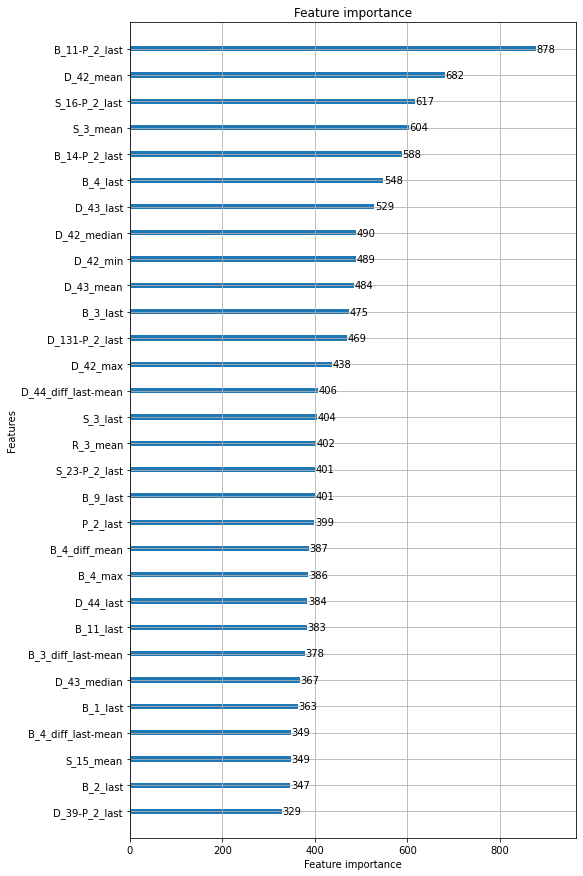

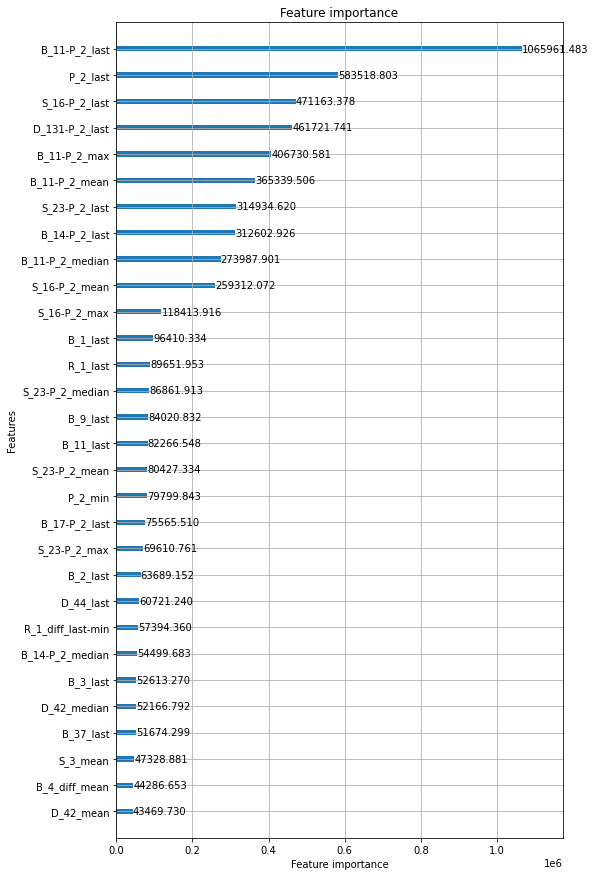

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.759377	valid_0's recall_at4: 0.614349	valid_0's norm_gini: 0.904406


[100]	valid_0's amex_metric: 0.765124	valid_0's recall_at4: 0.621713	valid_0's norm_gini: 0.908536


[150]	valid_0's amex_metric: 0.770336	valid_0's recall_at4: 0.629708	valid_0's norm_gini: 0.910965


[200]	valid_0's amex_metric: 0.771794	valid_0's recall_at4: 0.631349	valid_0's norm_gini: 0.912239


[250]	valid_0's amex_metric: 0.77558	valid_0's recall_at4: 0.637071	valid_0's norm_gini: 0.914088


[300]	valid_0's amex_metric: 0.778272	valid_0's recall_at4: 0.641027	valid_0's norm_gini: 0.915518


[350]	valid_0's amex_metric: 0.779984	valid_0's recall_at4: 0.643593	valid_0's norm_gini: 0.916375


[400]	valid_0's amex_metric: 0.781339	valid_0's recall_at4: 0.645655	valid_0's norm_gini: 0.917022


[450]	valid_0's amex_metric: 0.784358	valid_0's recall_at4: 0.650663	valid_0's norm_gini: 0.918053


[500]	valid_0's amex_metric: 0.786673	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.919274


[550]	valid_0's amex_metric: 0.788986	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.920156


[600]	valid_0's amex_metric: 0.790402	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.920926


[650]	valid_0's amex_metric: 0.790904	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.9213


[700]	valid_0's amex_metric: 0.791723	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.921801


[750]	valid_0's amex_metric: 0.792265	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.922042


[800]	valid_0's amex_metric: 0.792823	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.922317


[850]	valid_0's amex_metric: 0.793072	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.922479


[900]	valid_0's amex_metric: 0.793206	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.922747


[950]	valid_0's amex_metric: 0.794018	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.923024


[1000]	valid_0's amex_metric: 0.794951	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.923291


[1050]	valid_0's amex_metric: 0.794682	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.923638


[1100]	valid_0's amex_metric: 0.794856	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.92386


[1150]	valid_0's amex_metric: 0.794974	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924052


[1200]	valid_0's amex_metric: 0.796681	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924142


[1250]	valid_0's amex_metric: 0.797165	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924311


[1300]	valid_0's amex_metric: 0.796595	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.92435


[1350]	valid_0's amex_metric: 0.79721	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.924444


[1400]	valid_0's amex_metric: 0.797561	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.924555


[1450]	valid_0's amex_metric: 0.797736	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.924695


[1500]	valid_0's amex_metric: 0.798091	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.924817


[1550]	valid_0's amex_metric: 0.797497	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924976


[1600]	valid_0's amex_metric: 0.797696	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925078


[1650]	valid_0's amex_metric: 0.797676	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925165


[1700]	valid_0's amex_metric: 0.798143	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925214


[1750]	valid_0's amex_metric: 0.798281	valid_0's recall_at4: 0.671239	valid_0's norm_gini: 0.925322


[1800]	valid_0's amex_metric: 0.798385	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.925447


[1850]	valid_0's amex_metric: 0.798715	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.925518


[1900]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925563


[1950]	valid_0's amex_metric: 0.799119	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.92561


[2000]	valid_0's amex_metric: 0.799443	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.925669


[2050]	valid_0's amex_metric: 0.799591	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925755


[2100]	valid_0's amex_metric: 0.799628	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925829


[2150]	valid_0's amex_metric: 0.79992	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.925909


[2200]	valid_0's amex_metric: 0.800563	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.925974


[2250]	valid_0's amex_metric: 0.800832	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.926007


[2300]	valid_0's amex_metric: 0.801078	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.926035


[2350]	valid_0's amex_metric: 0.800548	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.926028


[2400]	valid_0's amex_metric: 0.800356	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.926023


[2450]	valid_0's amex_metric: 0.80079	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.926092


[2500]	valid_0's amex_metric: 0.801058	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.926122


[2550]	valid_0's amex_metric: 0.800941	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.92614


[2600]	valid_0's amex_metric: 0.800986	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.926146


[2650]	valid_0's amex_metric: 0.801038	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.926166


[2700]	valid_0's amex_metric: 0.801074	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.926153


[2750]	valid_0's amex_metric: 0.800868	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.926163


[2800]	valid_0's amex_metric: 0.800726	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.926131


[2850]	valid_0's amex_metric: 0.800244	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926135


[2900]	valid_0's amex_metric: 0.800143	valid_0's recall_at4: 0.674143	valid_0's norm_gini: 0.926143


[2950]	valid_0's amex_metric: 0.800182	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.926138


[3000]	valid_0's amex_metric: 0.800319	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.926159


[3050]	valid_0's amex_metric: 0.800317	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.926155


[3100]	valid_0's amex_metric: 0.800268	valid_0's recall_at4: 0.674395	valid_0's norm_gini: 0.92614


[3150]	valid_0's amex_metric: 0.7999	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926162


[3200]	valid_0's amex_metric: 0.800254	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926154


[3250]	valid_0's amex_metric: 0.800522	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.926185


[3300]	valid_0's amex_metric: 0.800615	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926204


[3350]	valid_0's amex_metric: 0.800545	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.92619


[3400]	valid_0's amex_metric: 0.800195	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.926205


[3450]	valid_0's amex_metric: 0.799553	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.926227


[3500]	valid_0's amex_metric: 0.799996	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926186


[3550]	valid_0's amex_metric: 0.799512	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926186


[3600]	valid_0's amex_metric: 0.799704	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926191


[3650]	valid_0's amex_metric: 0.799939	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926199


[3700]	valid_0's amex_metric: 0.80044	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.92619


[3750]	valid_0's amex_metric: 0.801041	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.926172


[3800]	valid_0's amex_metric: 0.800081	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.926147


[3850]	valid_0's amex_metric: 0.800117	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926133


[3900]	valid_0's amex_metric: 0.800531	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.92612


[3950]	valid_0's amex_metric: 0.80025	valid_0's recall_at4: 0.674395	valid_0's norm_gini: 0.926106


[4000]	valid_0's amex_metric: 0.800195	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926122


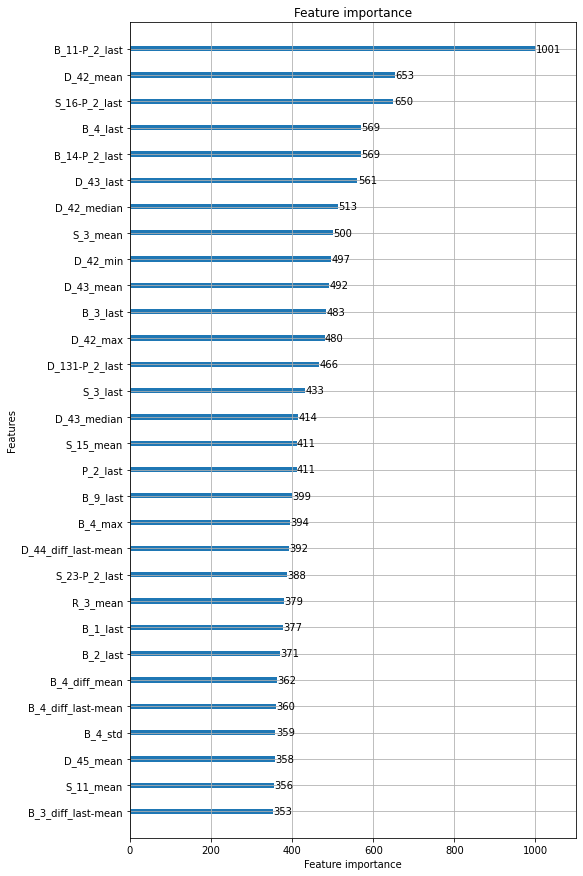

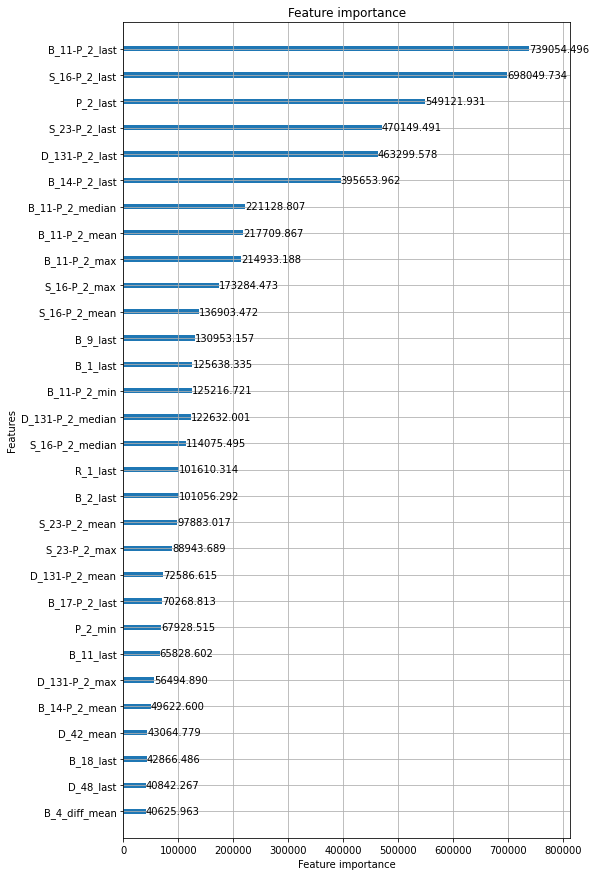

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758805	valid_0's recall_at4: 0.612834	valid_0's norm_gini: 0.904775


[100]	valid_0's amex_metric: 0.766089	valid_0's recall_at4: 0.623059	valid_0's norm_gini: 0.909118


[150]	valid_0's amex_metric: 0.769875	valid_0's recall_at4: 0.628403	valid_0's norm_gini: 0.911347


[200]	valid_0's amex_metric: 0.773212	valid_0's recall_at4: 0.633537	valid_0's norm_gini: 0.912887


[250]	valid_0's amex_metric: 0.776951	valid_0's recall_at4: 0.639344	valid_0's norm_gini: 0.914559


[300]	valid_0's amex_metric: 0.779749	valid_0's recall_at4: 0.643593	valid_0's norm_gini: 0.915904


[350]	valid_0's amex_metric: 0.780516	valid_0's recall_at4: 0.644309	valid_0's norm_gini: 0.916723


[400]	valid_0's amex_metric: 0.782109	valid_0's recall_at4: 0.646834	valid_0's norm_gini: 0.917384


[450]	valid_0's amex_metric: 0.783582	valid_0's recall_at4: 0.648769	valid_0's norm_gini: 0.918395


[500]	valid_0's amex_metric: 0.785356	valid_0's recall_at4: 0.65121	valid_0's norm_gini: 0.919502


[550]	valid_0's amex_metric: 0.787107	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.920436


[600]	valid_0's amex_metric: 0.788934	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.921146


[650]	valid_0's amex_metric: 0.789516	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.921596


[700]	valid_0's amex_metric: 0.790141	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.922087


[750]	valid_0's amex_metric: 0.7903	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922321


[800]	valid_0's amex_metric: 0.790239	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.922662


[850]	valid_0's amex_metric: 0.790567	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.922938


[900]	valid_0's amex_metric: 0.7909	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.923184


[950]	valid_0's amex_metric: 0.791689	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923458


[1000]	valid_0's amex_metric: 0.791769	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.923743


[1050]	valid_0's amex_metric: 0.793147	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.924101


[1100]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924308


[1150]	valid_0's amex_metric: 0.793741	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924448


[1200]	valid_0's amex_metric: 0.793617	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924579


[1250]	valid_0's amex_metric: 0.794009	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924732


[1300]	valid_0's amex_metric: 0.794623	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.924782


[1350]	valid_0's amex_metric: 0.794245	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924867


[1400]	valid_0's amex_metric: 0.79456	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924992


[1450]	valid_0's amex_metric: 0.795119	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.925143


[1500]	valid_0's amex_metric: 0.794856	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.925205


[1550]	valid_0's amex_metric: 0.795303	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.925383


[1600]	valid_0's amex_metric: 0.795683	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925472


[1650]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.925532


[1700]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.925576


[1750]	valid_0's amex_metric: 0.795365	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925677


[1800]	valid_0's amex_metric: 0.795504	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.925744


[1850]	valid_0's amex_metric: 0.795963	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925821


[1900]	valid_0's amex_metric: 0.796645	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.925837


[1950]	valid_0's amex_metric: 0.796601	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925876


[2000]	valid_0's amex_metric: 0.796521	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.925926


[2050]	valid_0's amex_metric: 0.797297	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.926006


[2100]	valid_0's amex_metric: 0.797513	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.926058


[2150]	valid_0's amex_metric: 0.797879	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.926118


[2200]	valid_0's amex_metric: 0.798374	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.926183


[2250]	valid_0's amex_metric: 0.798557	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926211


[2300]	valid_0's amex_metric: 0.798397	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.926228


[2350]	valid_0's amex_metric: 0.798777	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926232


[2400]	valid_0's amex_metric: 0.798973	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.926244


[2450]	valid_0's amex_metric: 0.799104	valid_0's recall_at4: 0.671955	valid_0's norm_gini: 0.926253


[2500]	valid_0's amex_metric: 0.799217	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.926269


[2550]	valid_0's amex_metric: 0.798849	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.926249


[2600]	valid_0's amex_metric: 0.798797	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926271


[2650]	valid_0's amex_metric: 0.798595	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926287


[2700]	valid_0's amex_metric: 0.798952	valid_0's recall_at4: 0.671618	valid_0's norm_gini: 0.926287


[2750]	valid_0's amex_metric: 0.798745	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.926334


[2800]	valid_0's amex_metric: 0.799164	valid_0's recall_at4: 0.671955	valid_0's norm_gini: 0.926374


[2850]	valid_0's amex_metric: 0.798985	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.926436


[2900]	valid_0's amex_metric: 0.799323	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.926438


[2950]	valid_0's amex_metric: 0.799094	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.926444


[3000]	valid_0's amex_metric: 0.798943	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.926437


[3050]	valid_0's amex_metric: 0.79903	valid_0's recall_at4: 0.671618	valid_0's norm_gini: 0.926442


[3100]	valid_0's amex_metric: 0.798579	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.926424


[3150]	valid_0's amex_metric: 0.798936	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.926422


[3200]	valid_0's amex_metric: 0.798686	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.926385


[3250]	valid_0's amex_metric: 0.798863	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.926445


[3300]	valid_0's amex_metric: 0.799245	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.926451


[3350]	valid_0's amex_metric: 0.799239	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.926439


[3400]	valid_0's amex_metric: 0.799472	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.926441


[3450]	valid_0's amex_metric: 0.799513	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.92644


[3500]	valid_0's amex_metric: 0.799495	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.926446


[3550]	valid_0's amex_metric: 0.799297	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.926429


[3600]	valid_0's amex_metric: 0.79985	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.92644


[3650]	valid_0's amex_metric: 0.799781	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926471


[3700]	valid_0's amex_metric: 0.80003	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926464


[3750]	valid_0's amex_metric: 0.799761	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926431


[3800]	valid_0's amex_metric: 0.799623	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926407


[3850]	valid_0's amex_metric: 0.799132	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.926393


[3900]	valid_0's amex_metric: 0.798715	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.9264


[3950]	valid_0's amex_metric: 0.798917	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926426


[4000]	valid_0's amex_metric: 0.798876	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926428


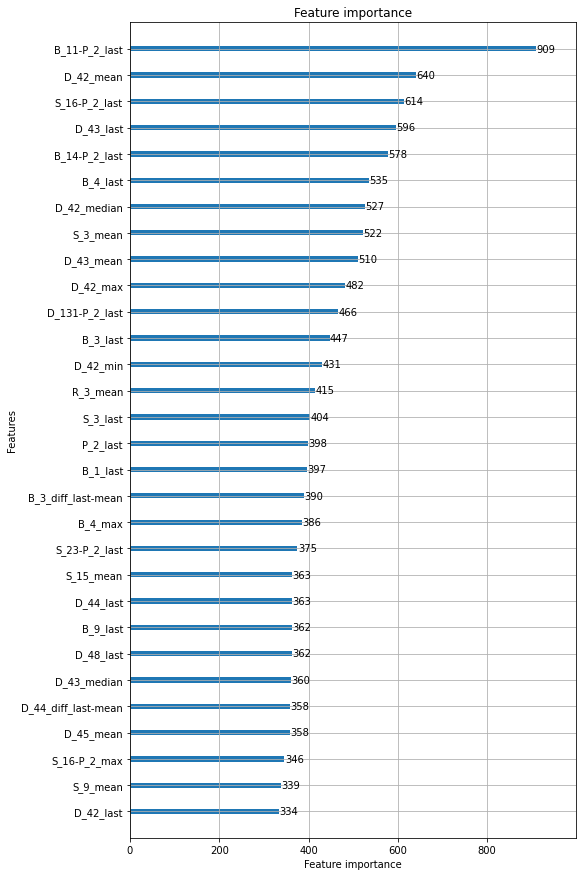

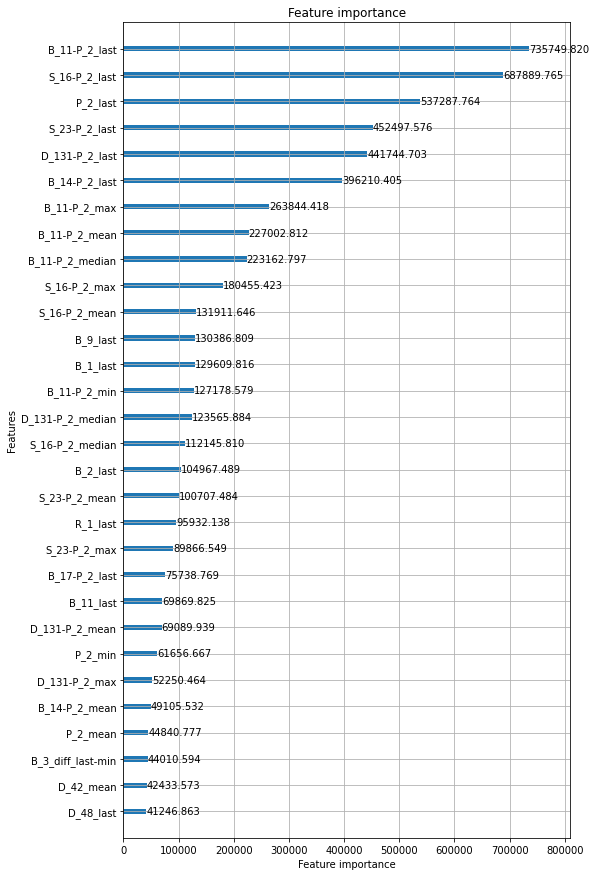

Training time: 217.81952461401622 min.
OOF recall_at4: 0.6702208233749621
OOF normalized_gini: 0.925823722448644
OOF competition metric: 0.798022272911803


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.754229	valid_0's recall_at4: 0.605697	valid_0's norm_gini: 0.90276


[100]	valid_0's amex_metric: 0.761155	valid_0's recall_at4: 0.615459	valid_0's norm_gini: 0.906852


[150]	valid_0's amex_metric: 0.764587	valid_0's recall_at4: 0.620003	valid_0's norm_gini: 0.90917


[200]	valid_0's amex_metric: 0.767739	valid_0's recall_at4: 0.624968	valid_0's norm_gini: 0.910509


[250]	valid_0's amex_metric: 0.771003	valid_0's recall_at4: 0.629639	valid_0's norm_gini: 0.912366


[300]	valid_0's amex_metric: 0.772928	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.913902


[350]	valid_0's amex_metric: 0.775415	valid_0's recall_at4: 0.636035	valid_0's norm_gini: 0.914796


[400]	valid_0's amex_metric: 0.776722	valid_0's recall_at4: 0.63797	valid_0's norm_gini: 0.915475


[450]	valid_0's amex_metric: 0.777787	valid_0's recall_at4: 0.639022	valid_0's norm_gini: 0.916553


[500]	valid_0's amex_metric: 0.781001	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.917679


[550]	valid_0's amex_metric: 0.782919	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.918611


[600]	valid_0's amex_metric: 0.785035	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.919392


[650]	valid_0's amex_metric: 0.785551	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.919793


[700]	valid_0's amex_metric: 0.787316	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.920251


[750]	valid_0's amex_metric: 0.787628	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.920498


[800]	valid_0's amex_metric: 0.788984	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.920811


[850]	valid_0's amex_metric: 0.788427	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.921084


[900]	valid_0's amex_metric: 0.788596	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.92134


[950]	valid_0's amex_metric: 0.789051	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.921618


[1000]	valid_0's amex_metric: 0.789205	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.921842


[1050]	valid_0's amex_metric: 0.790136	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.922147


[1100]	valid_0's amex_metric: 0.791056	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.922346


[1150]	valid_0's amex_metric: 0.791643	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92251


[1200]	valid_0's amex_metric: 0.79206	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922671


[1250]	valid_0's amex_metric: 0.79194	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.92281


[1300]	valid_0's amex_metric: 0.792366	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.922862


[1350]	valid_0's amex_metric: 0.792333	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.922923


[1400]	valid_0's amex_metric: 0.792138	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923037


[1450]	valid_0's amex_metric: 0.792946	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.923139


[1500]	valid_0's amex_metric: 0.793035	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.923233


[1550]	valid_0's amex_metric: 0.793533	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.923346


[1600]	valid_0's amex_metric: 0.793453	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923438


[1650]	valid_0's amex_metric: 0.793476	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923526


[1700]	valid_0's amex_metric: 0.79422	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923624


[1750]	valid_0's amex_metric: 0.794689	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.92368


[1800]	valid_0's amex_metric: 0.794315	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.923773


[1850]	valid_0's amex_metric: 0.794341	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923867


[1900]	valid_0's amex_metric: 0.794126	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.9239


[1950]	valid_0's amex_metric: 0.794448	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923912


[2000]	valid_0's amex_metric: 0.794241	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923961


[2050]	valid_0's amex_metric: 0.794192	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.92399


[2100]	valid_0's amex_metric: 0.794095	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924005


[2150]	valid_0's amex_metric: 0.794177	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924043


[2200]	valid_0's amex_metric: 0.794468	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924078


[2250]	valid_0's amex_metric: 0.794236	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924078


[2300]	valid_0's amex_metric: 0.794536	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924089


[2350]	valid_0's amex_metric: 0.795411	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924071


[2400]	valid_0's amex_metric: 0.794852	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924088


[2450]	valid_0's amex_metric: 0.794863	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924111


[2500]	valid_0's amex_metric: 0.794937	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924091


[2550]	valid_0's amex_metric: 0.795082	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924128


[2600]	valid_0's amex_metric: 0.795299	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924141


[2650]	valid_0's amex_metric: 0.795253	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924133


[2700]	valid_0's amex_metric: 0.794944	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924146


[2750]	valid_0's amex_metric: 0.795005	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924185


[2800]	valid_0's amex_metric: 0.794998	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.92417


[2850]	valid_0's amex_metric: 0.795202	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924199


[2900]	valid_0's amex_metric: 0.795145	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924171


[2950]	valid_0's amex_metric: 0.795104	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924172


[3000]	valid_0's amex_metric: 0.795019	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924213


[3050]	valid_0's amex_metric: 0.794357	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924236


[3100]	valid_0's amex_metric: 0.795046	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924225


[3150]	valid_0's amex_metric: 0.794768	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924215


[3200]	valid_0's amex_metric: 0.794878	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924225


[3250]	valid_0's amex_metric: 0.794827	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.924207


[3300]	valid_0's amex_metric: 0.794613	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924201


[3350]	valid_0's amex_metric: 0.794583	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924182


[3400]	valid_0's amex_metric: 0.794879	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924186


[3450]	valid_0's amex_metric: 0.794622	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924176


[3500]	valid_0's amex_metric: 0.794601	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924175


[3550]	valid_0's amex_metric: 0.794852	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924215


[3600]	valid_0's amex_metric: 0.794482	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924191


[3650]	valid_0's amex_metric: 0.79477	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924177


[3700]	valid_0's amex_metric: 0.794864	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924154


[3750]	valid_0's amex_metric: 0.79494	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924139


[3800]	valid_0's amex_metric: 0.794442	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.92411


[3850]	valid_0's amex_metric: 0.793954	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.924102


[3900]	valid_0's amex_metric: 0.794346	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.924088


[3950]	valid_0's amex_metric: 0.794144	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924062


[4000]	valid_0's amex_metric: 0.793902	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.92404


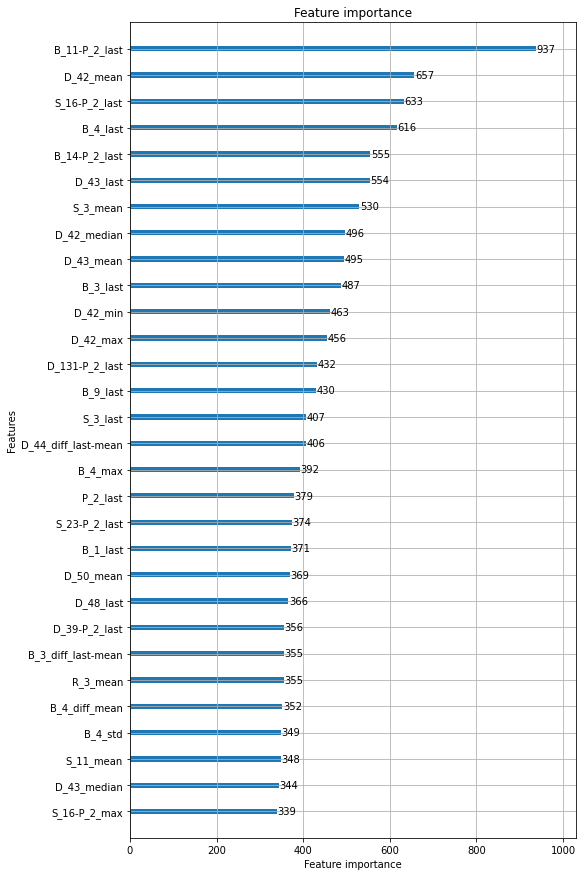

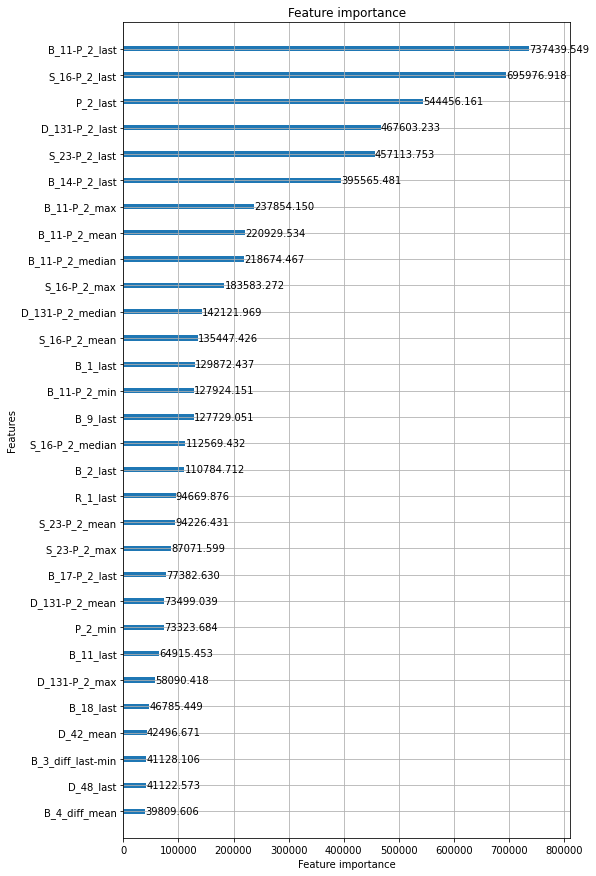

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.754127	valid_0's recall_at4: 0.604351	valid_0's norm_gini: 0.903903


[100]	valid_0's amex_metric: 0.761665	valid_0's recall_at4: 0.615375	valid_0's norm_gini: 0.907955


[150]	valid_0's amex_metric: 0.76491	valid_0's recall_at4: 0.619583	valid_0's norm_gini: 0.910237


[200]	valid_0's amex_metric: 0.767629	valid_0's recall_at4: 0.623664	valid_0's norm_gini: 0.911594


[250]	valid_0's amex_metric: 0.769907	valid_0's recall_at4: 0.626525	valid_0's norm_gini: 0.913289


[300]	valid_0's amex_metric: 0.773014	valid_0's recall_at4: 0.631364	valid_0's norm_gini: 0.914664


[350]	valid_0's amex_metric: 0.774329	valid_0's recall_at4: 0.633047	valid_0's norm_gini: 0.91561


[400]	valid_0's amex_metric: 0.775682	valid_0's recall_at4: 0.635067	valid_0's norm_gini: 0.916298


[450]	valid_0's amex_metric: 0.777954	valid_0's recall_at4: 0.638475	valid_0's norm_gini: 0.917433


[500]	valid_0's amex_metric: 0.780237	valid_0's recall_at4: 0.641968	valid_0's norm_gini: 0.918507


[550]	valid_0's amex_metric: 0.781213	valid_0's recall_at4: 0.642935	valid_0's norm_gini: 0.91949


[600]	valid_0's amex_metric: 0.783305	valid_0's recall_at4: 0.646344	valid_0's norm_gini: 0.920266


[650]	valid_0's amex_metric: 0.783184	valid_0's recall_at4: 0.645754	valid_0's norm_gini: 0.920613


[700]	valid_0's amex_metric: 0.784968	valid_0's recall_at4: 0.648784	valid_0's norm_gini: 0.921151


[750]	valid_0's amex_metric: 0.785699	valid_0's recall_at4: 0.649878	valid_0's norm_gini: 0.921521


[800]	valid_0's amex_metric: 0.787097	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.921876


[850]	valid_0's amex_metric: 0.786998	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.922225


[900]	valid_0's amex_metric: 0.787277	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.922488


[950]	valid_0's amex_metric: 0.787663	valid_0's recall_at4: 0.652445	valid_0's norm_gini: 0.922881


[1000]	valid_0's amex_metric: 0.788577	valid_0's recall_at4: 0.654002	valid_0's norm_gini: 0.923152


[1050]	valid_0's amex_metric: 0.789849	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.923508


[1100]	valid_0's amex_metric: 0.789796	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.923698


[1150]	valid_0's amex_metric: 0.789814	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923901


[1200]	valid_0's amex_metric: 0.790187	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.924016


[1250]	valid_0's amex_metric: 0.790492	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.924163


[1300]	valid_0's amex_metric: 0.791391	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.924195


[1350]	valid_0's amex_metric: 0.79112	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.924284


[1400]	valid_0's amex_metric: 0.791777	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924462


[1450]	valid_0's amex_metric: 0.792036	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.924559


[1500]	valid_0's amex_metric: 0.792896	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924679


[1550]	valid_0's amex_metric: 0.792709	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924768


[1600]	valid_0's amex_metric: 0.793642	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.924867


[1650]	valid_0's amex_metric: 0.793456	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924958


[1700]	valid_0's amex_metric: 0.793792	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.925041


[1750]	valid_0's amex_metric: 0.794114	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.925096


[1800]	valid_0's amex_metric: 0.794159	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.925144


[1850]	valid_0's amex_metric: 0.794049	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.925217


[1900]	valid_0's amex_metric: 0.79379	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.925247


[1950]	valid_0's amex_metric: 0.793865	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925271


[2000]	valid_0's amex_metric: 0.793526	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.92535


[2050]	valid_0's amex_metric: 0.793507	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925396


[2100]	valid_0's amex_metric: 0.793224	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.925462


[2150]	valid_0's amex_metric: 0.793765	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.925534


[2200]	valid_0's amex_metric: 0.794015	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92557


[2250]	valid_0's amex_metric: 0.794115	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.925603


[2300]	valid_0's amex_metric: 0.793625	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925633


[2350]	valid_0's amex_metric: 0.793636	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925655


[2400]	valid_0's amex_metric: 0.794208	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925704


[2450]	valid_0's amex_metric: 0.794627	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925702


[2500]	valid_0's amex_metric: 0.794696	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.925755


[2550]	valid_0's amex_metric: 0.794684	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.925773


[2600]	valid_0's amex_metric: 0.794872	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925813


[2650]	valid_0's amex_metric: 0.794887	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.9258


[2700]	valid_0's amex_metric: 0.794668	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925824


[2750]	valid_0's amex_metric: 0.794468	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925847


[2800]	valid_0's amex_metric: 0.794276	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.925882


[2850]	valid_0's amex_metric: 0.794843	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925882


[2900]	valid_0's amex_metric: 0.794519	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.925906


[2950]	valid_0's amex_metric: 0.794606	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.925869


[3000]	valid_0's amex_metric: 0.79436	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.925882


[3050]	valid_0's amex_metric: 0.794704	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925898


[3100]	valid_0's amex_metric: 0.794539	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.925946


[3150]	valid_0's amex_metric: 0.794477	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.925947


[3200]	valid_0's amex_metric: 0.79378	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925943


[3250]	valid_0's amex_metric: 0.793726	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.92596


[3300]	valid_0's amex_metric: 0.794572	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925928


[3350]	valid_0's amex_metric: 0.794411	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.9259


[3400]	valid_0's amex_metric: 0.794847	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925888


[3450]	valid_0's amex_metric: 0.794593	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925885


[3500]	valid_0's amex_metric: 0.79416	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925861


[3550]	valid_0's amex_metric: 0.794292	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925872


[3600]	valid_0's amex_metric: 0.794286	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925861


[3650]	valid_0's amex_metric: 0.793858	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.925888


[3700]	valid_0's amex_metric: 0.793823	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.925903


[3750]	valid_0's amex_metric: 0.79383	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.925874


[3800]	valid_0's amex_metric: 0.793673	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.925855


[3850]	valid_0's amex_metric: 0.794189	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.925835


[3900]	valid_0's amex_metric: 0.794136	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925812


[3950]	valid_0's amex_metric: 0.794988	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925834


[4000]	valid_0's amex_metric: 0.794459	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925828


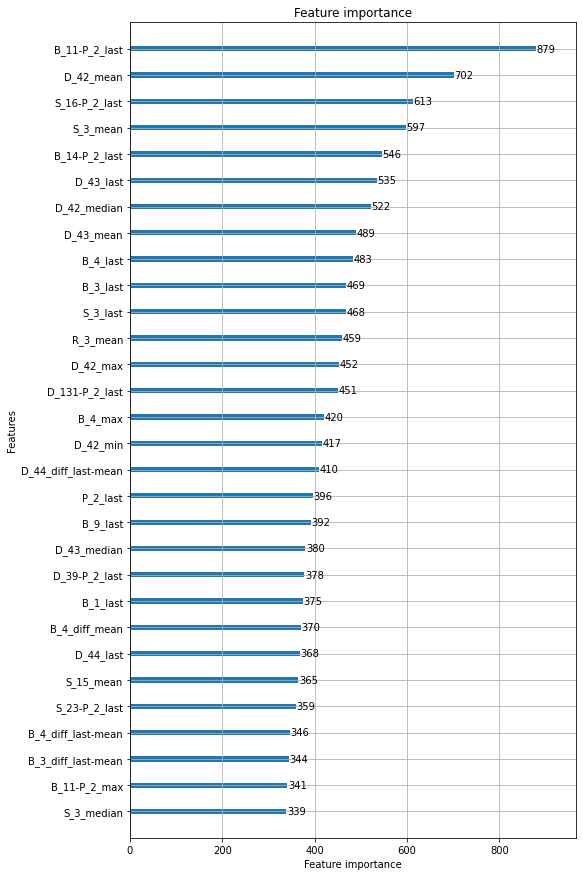

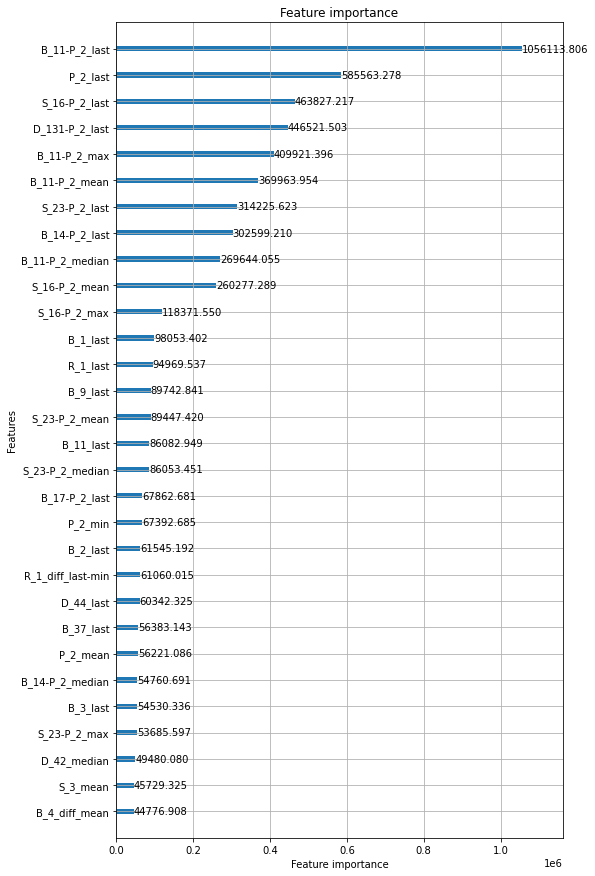

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.756517	valid_0's recall_at4: 0.61062	valid_0's norm_gini: 0.902413


[100]	valid_0's amex_metric: 0.764604	valid_0's recall_at4: 0.622318	valid_0's norm_gini: 0.90689


[150]	valid_0's amex_metric: 0.769114	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.909431


[200]	valid_0's amex_metric: 0.77143	valid_0's recall_at4: 0.632079	valid_0's norm_gini: 0.91078


[250]	valid_0's amex_metric: 0.774756	valid_0's recall_at4: 0.63675	valid_0's norm_gini: 0.912762


[300]	valid_0's amex_metric: 0.777207	valid_0's recall_at4: 0.640158	valid_0's norm_gini: 0.914255


[350]	valid_0's amex_metric: 0.779123	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.915143


[400]	valid_0's amex_metric: 0.77931	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.915895


[450]	valid_0's amex_metric: 0.78221	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.917067


[500]	valid_0's amex_metric: 0.784531	valid_0's recall_at4: 0.650846	valid_0's norm_gini: 0.918217


[550]	valid_0's amex_metric: 0.787019	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.919364


[600]	valid_0's amex_metric: 0.788334	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.920269


[650]	valid_0's amex_metric: 0.789242	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.920696


[700]	valid_0's amex_metric: 0.791165	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.921218


[750]	valid_0's amex_metric: 0.791767	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.921538


[800]	valid_0's amex_metric: 0.792049	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.921891


[850]	valid_0's amex_metric: 0.792464	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.922217


[900]	valid_0's amex_metric: 0.792786	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.922523


[950]	valid_0's amex_metric: 0.793649	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.922903


[1000]	valid_0's amex_metric: 0.794702	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.923199


[1050]	valid_0's amex_metric: 0.79573	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.923573


[1100]	valid_0's amex_metric: 0.795963	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.923828


[1150]	valid_0's amex_metric: 0.796049	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924001


[1200]	valid_0's amex_metric: 0.795964	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924124


[1250]	valid_0's amex_metric: 0.796696	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.924326


[1300]	valid_0's amex_metric: 0.796612	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.92437


[1350]	valid_0's amex_metric: 0.796904	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.924449


[1400]	valid_0's amex_metric: 0.796764	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924631


[1450]	valid_0's amex_metric: 0.797763	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.924778


[1500]	valid_0's amex_metric: 0.79747	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924907


[1550]	valid_0's amex_metric: 0.79806	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925119


[1600]	valid_0's amex_metric: 0.798213	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925131


[1650]	valid_0's amex_metric: 0.798161	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.92528


[1700]	valid_0's amex_metric: 0.798709	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.925323


[1750]	valid_0's amex_metric: 0.799176	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925415


[1800]	valid_0's amex_metric: 0.798876	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925447


[1850]	valid_0's amex_metric: 0.799217	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925539


[1900]	valid_0's amex_metric: 0.799091	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.92554


[1950]	valid_0's amex_metric: 0.799083	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925609


[2000]	valid_0's amex_metric: 0.798844	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925636


[2050]	valid_0's amex_metric: 0.799832	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.925677


[2100]	valid_0's amex_metric: 0.799629	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925775


[2150]	valid_0's amex_metric: 0.800096	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.925868


[2200]	valid_0's amex_metric: 0.800176	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.925902


[2250]	valid_0's amex_metric: 0.800148	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.925929


[2300]	valid_0's amex_metric: 0.799802	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.92591


[2350]	valid_0's amex_metric: 0.79959	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925906


[2400]	valid_0's amex_metric: 0.799245	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925933


[2450]	valid_0's amex_metric: 0.799265	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926014


[2500]	valid_0's amex_metric: 0.800319	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.92602


[2550]	valid_0's amex_metric: 0.800383	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.92602


[2600]	valid_0's amex_metric: 0.800408	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926029


[2650]	valid_0's amex_metric: 0.801042	valid_0's recall_at4: 0.676008	valid_0's norm_gini: 0.926076


[2700]	valid_0's amex_metric: 0.800814	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.926084


[2750]	valid_0's amex_metric: 0.800993	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.926104


[2800]	valid_0's amex_metric: 0.801018	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926113


[2850]	valid_0's amex_metric: 0.800987	valid_0's recall_at4: 0.675839	valid_0's norm_gini: 0.926135


[2900]	valid_0's amex_metric: 0.800842	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926181


[2950]	valid_0's amex_metric: 0.800978	valid_0's recall_at4: 0.675839	valid_0's norm_gini: 0.926116


[3000]	valid_0's amex_metric: 0.800686	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.926122


[3050]	valid_0's amex_metric: 0.799945	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92607


[3100]	valid_0's amex_metric: 0.800541	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.926085


[3150]	valid_0's amex_metric: 0.800424	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926145


[3200]	valid_0's amex_metric: 0.80011	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926147


[3250]	valid_0's amex_metric: 0.800024	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926144


[3300]	valid_0's amex_metric: 0.799511	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926128


[3350]	valid_0's amex_metric: 0.799654	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.92612


[3400]	valid_0's amex_metric: 0.799345	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926132


[3450]	valid_0's amex_metric: 0.799616	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.92617


[3500]	valid_0's amex_metric: 0.79979	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926182


[3550]	valid_0's amex_metric: 0.799777	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926113


[3600]	valid_0's amex_metric: 0.799555	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926089


[3650]	valid_0's amex_metric: 0.799748	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926096


[3700]	valid_0's amex_metric: 0.798966	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.92609


[3750]	valid_0's amex_metric: 0.799201	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926097


[3800]	valid_0's amex_metric: 0.800113	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.926111


[3850]	valid_0's amex_metric: 0.800083	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926094


[3900]	valid_0's amex_metric: 0.799463	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926074


[3950]	valid_0's amex_metric: 0.799758	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926033


[4000]	valid_0's amex_metric: 0.799924	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926028


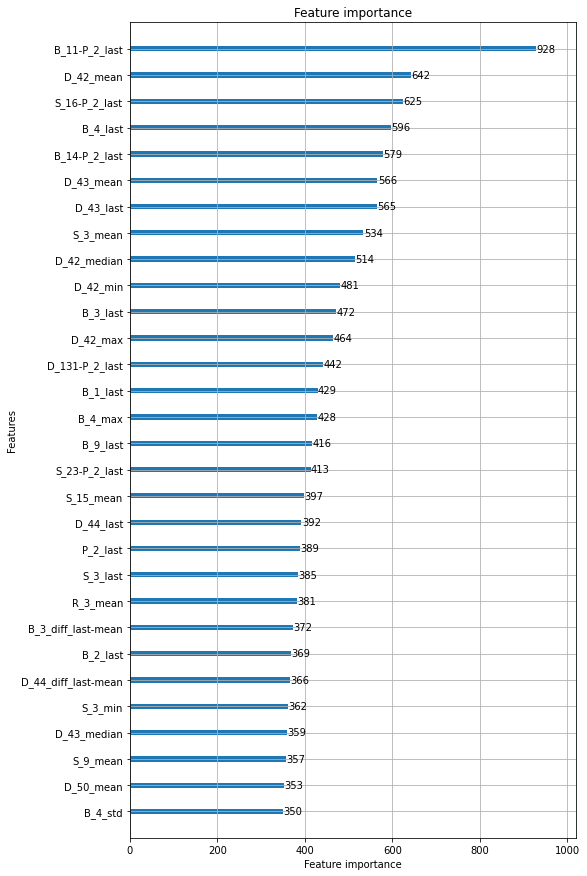

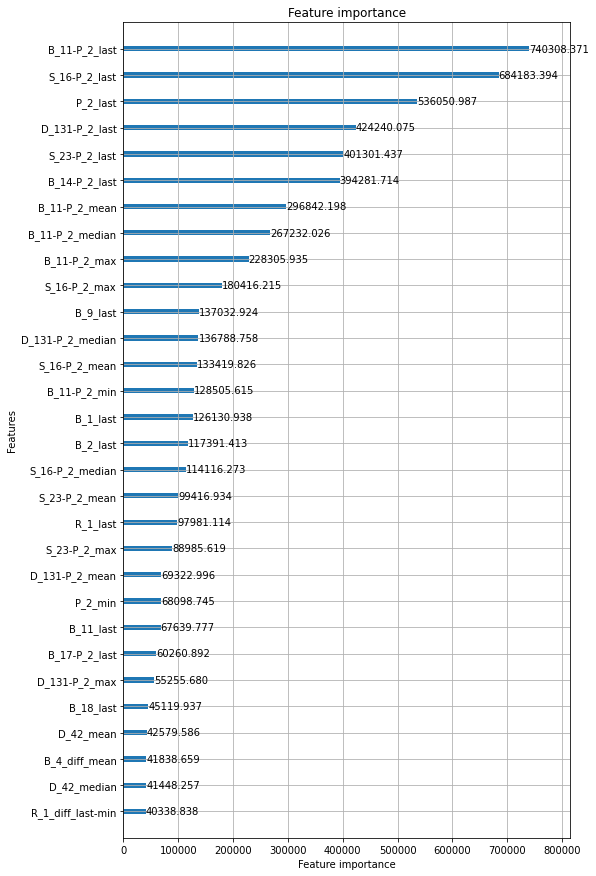

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.760702	valid_0's recall_at4: 0.614812	valid_0's norm_gini: 0.906592


[100]	valid_0's amex_metric: 0.769821	valid_0's recall_at4: 0.628487	valid_0's norm_gini: 0.911154


[150]	valid_0's amex_metric: 0.773416	valid_0's recall_at4: 0.633495	valid_0's norm_gini: 0.913337


[200]	valid_0's amex_metric: 0.77524	valid_0's recall_at4: 0.635809	valid_0's norm_gini: 0.914672


[250]	valid_0's amex_metric: 0.779003	valid_0's recall_at4: 0.641532	valid_0's norm_gini: 0.916474


[300]	valid_0's amex_metric: 0.782224	valid_0's recall_at4: 0.646455	valid_0's norm_gini: 0.917993


[350]	valid_0's amex_metric: 0.78394	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.918859


[400]	valid_0's amex_metric: 0.785221	valid_0's recall_at4: 0.650999	valid_0's norm_gini: 0.919443


[450]	valid_0's amex_metric: 0.7878	valid_0's recall_at4: 0.655123	valid_0's norm_gini: 0.920477


[500]	valid_0's amex_metric: 0.789698	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.921663


[550]	valid_0's amex_metric: 0.791703	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.922687


[600]	valid_0's amex_metric: 0.793758	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.923556


[650]	valid_0's amex_metric: 0.794596	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.92397


[700]	valid_0's amex_metric: 0.796268	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.924453


[750]	valid_0's amex_metric: 0.796265	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.924741


[800]	valid_0's amex_metric: 0.7967	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925149


[850]	valid_0's amex_metric: 0.796601	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925456


[900]	valid_0's amex_metric: 0.797621	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.925686


[950]	valid_0's amex_metric: 0.798508	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.92603


[1000]	valid_0's amex_metric: 0.798398	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.926356


[1050]	valid_0's amex_metric: 0.798821	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.926697


[1100]	valid_0's amex_metric: 0.799556	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.926947


[1150]	valid_0's amex_metric: 0.799405	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.927066


[1200]	valid_0's amex_metric: 0.7998	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.927182


[1250]	valid_0's amex_metric: 0.800556	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.927307


[1300]	valid_0's amex_metric: 0.800274	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.927331


[1350]	valid_0's amex_metric: 0.801007	valid_0's recall_at4: 0.674605	valid_0's norm_gini: 0.927409


[1400]	valid_0's amex_metric: 0.801174	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927573


[1450]	valid_0's amex_metric: 0.801415	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927719


[1500]	valid_0's amex_metric: 0.801855	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927801


[1550]	valid_0's amex_metric: 0.802574	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.927934


[1600]	valid_0's amex_metric: 0.802555	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.928064


[1650]	valid_0's amex_metric: 0.802846	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.9281


[1700]	valid_0's amex_metric: 0.802952	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.928142


[1750]	valid_0's amex_metric: 0.803842	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.92824


[1800]	valid_0's amex_metric: 0.803346	valid_0's recall_at4: 0.678393	valid_0's norm_gini: 0.9283


[1850]	valid_0's amex_metric: 0.803553	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928376


[1900]	valid_0's amex_metric: 0.803464	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.928409


[1950]	valid_0's amex_metric: 0.803657	valid_0's recall_at4: 0.678855	valid_0's norm_gini: 0.928458


[2000]	valid_0's amex_metric: 0.804307	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.928538


[2050]	valid_0's amex_metric: 0.804168	valid_0's recall_at4: 0.679697	valid_0's norm_gini: 0.928638


[2100]	valid_0's amex_metric: 0.804229	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.928677


[2150]	valid_0's amex_metric: 0.804442	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928723


[2200]	valid_0's amex_metric: 0.804853	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.928788


[2250]	valid_0's amex_metric: 0.804731	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.928798


[2300]	valid_0's amex_metric: 0.804858	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.928799


[2350]	valid_0's amex_metric: 0.804742	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.928818


[2400]	valid_0's amex_metric: 0.805125	valid_0's recall_at4: 0.681422	valid_0's norm_gini: 0.928827


[2450]	valid_0's amex_metric: 0.804832	valid_0's recall_at4: 0.680833	valid_0's norm_gini: 0.928832


[2500]	valid_0's amex_metric: 0.804974	valid_0's recall_at4: 0.681086	valid_0's norm_gini: 0.928863


[2550]	valid_0's amex_metric: 0.805314	valid_0's recall_at4: 0.681759	valid_0's norm_gini: 0.928869


[2600]	valid_0's amex_metric: 0.805351	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.92886


[2650]	valid_0's amex_metric: 0.805137	valid_0's recall_at4: 0.681422	valid_0's norm_gini: 0.928852


[2700]	valid_0's amex_metric: 0.805238	valid_0's recall_at4: 0.681591	valid_0's norm_gini: 0.928886


[2750]	valid_0's amex_metric: 0.805503	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.928868


[2800]	valid_0's amex_metric: 0.804932	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928862


[2850]	valid_0's amex_metric: 0.805378	valid_0's recall_at4: 0.681885	valid_0's norm_gini: 0.92887


[2900]	valid_0's amex_metric: 0.805792	valid_0's recall_at4: 0.682685	valid_0's norm_gini: 0.928899


[2950]	valid_0's amex_metric: 0.805566	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.928868


[3000]	valid_0's amex_metric: 0.805368	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.928893


[3050]	valid_0's amex_metric: 0.805382	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.92892


[3100]	valid_0's amex_metric: 0.805551	valid_0's recall_at4: 0.68218	valid_0's norm_gini: 0.928921


[3150]	valid_0's amex_metric: 0.805863	valid_0's recall_at4: 0.682811	valid_0's norm_gini: 0.928916


[3200]	valid_0's amex_metric: 0.806156	valid_0's recall_at4: 0.6834	valid_0's norm_gini: 0.928912


[3250]	valid_0's amex_metric: 0.806591	valid_0's recall_at4: 0.684242	valid_0's norm_gini: 0.92894


[3300]	valid_0's amex_metric: 0.806069	valid_0's recall_at4: 0.68319	valid_0's norm_gini: 0.928949


[3350]	valid_0's amex_metric: 0.806313	valid_0's recall_at4: 0.683694	valid_0's norm_gini: 0.928931


[3400]	valid_0's amex_metric: 0.806036	valid_0's recall_at4: 0.683147	valid_0's norm_gini: 0.928924


[3450]	valid_0's amex_metric: 0.805894	valid_0's recall_at4: 0.682853	valid_0's norm_gini: 0.928934


[3500]	valid_0's amex_metric: 0.806346	valid_0's recall_at4: 0.683737	valid_0's norm_gini: 0.928955


[3550]	valid_0's amex_metric: 0.806309	valid_0's recall_at4: 0.683652	valid_0's norm_gini: 0.928966


[3600]	valid_0's amex_metric: 0.805898	valid_0's recall_at4: 0.682853	valid_0's norm_gini: 0.928943


[3650]	valid_0's amex_metric: 0.806	valid_0's recall_at4: 0.683063	valid_0's norm_gini: 0.928937


[3700]	valid_0's amex_metric: 0.80594	valid_0's recall_at4: 0.682937	valid_0's norm_gini: 0.928943


[3750]	valid_0's amex_metric: 0.806061	valid_0's recall_at4: 0.68319	valid_0's norm_gini: 0.928932


[3800]	valid_0's amex_metric: 0.805831	valid_0's recall_at4: 0.682727	valid_0's norm_gini: 0.928936


[3850]	valid_0's amex_metric: 0.805836	valid_0's recall_at4: 0.682727	valid_0's norm_gini: 0.928945


[3900]	valid_0's amex_metric: 0.805772	valid_0's recall_at4: 0.682643	valid_0's norm_gini: 0.928902


[3950]	valid_0's amex_metric: 0.805555	valid_0's recall_at4: 0.682222	valid_0's norm_gini: 0.928888


[4000]	valid_0's amex_metric: 0.805434	valid_0's recall_at4: 0.681969	valid_0's norm_gini: 0.928899


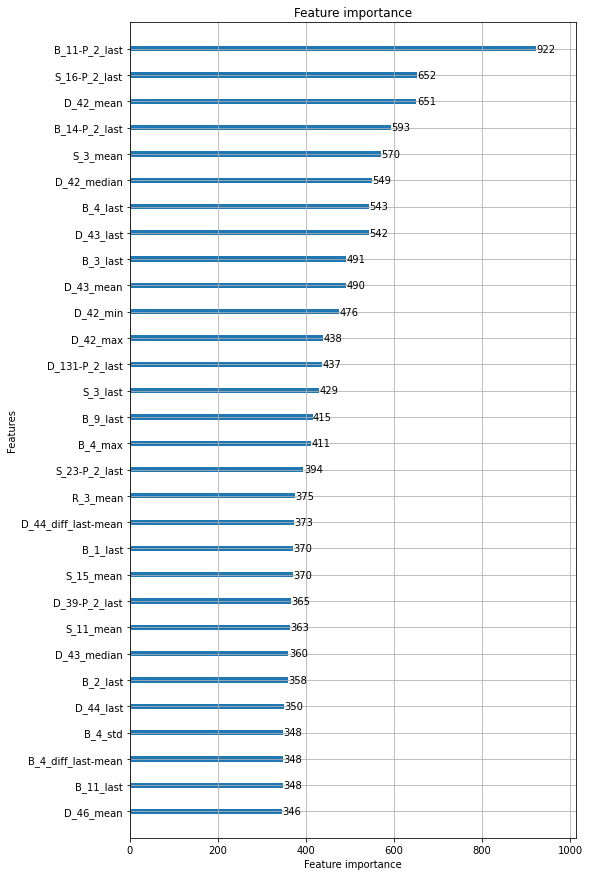

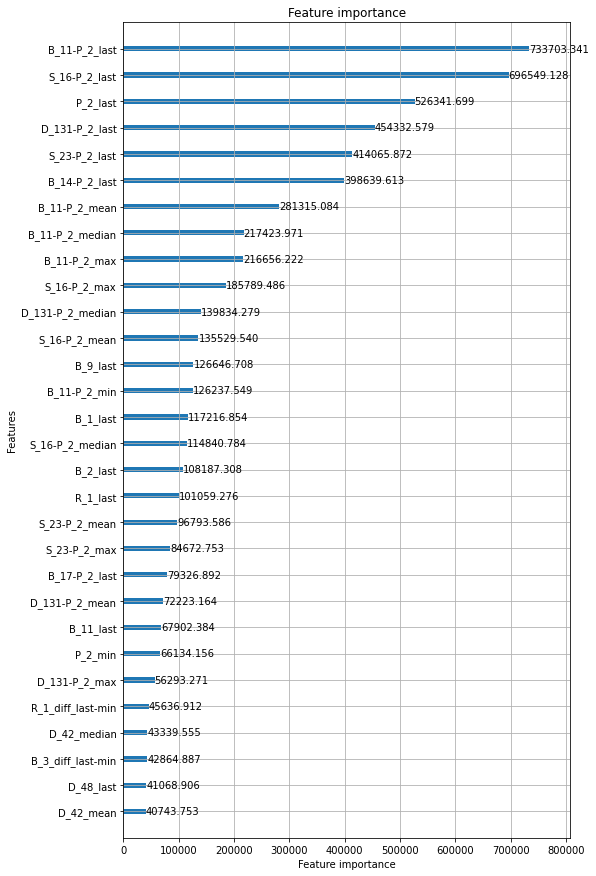

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758422	valid_0's recall_at4: 0.613255	valid_0's norm_gini: 0.903589


[100]	valid_0's amex_metric: 0.766727	valid_0's recall_at4: 0.625794	valid_0's norm_gini: 0.90766


[150]	valid_0's amex_metric: 0.770449	valid_0's recall_at4: 0.630928	valid_0's norm_gini: 0.90997


[200]	valid_0's amex_metric: 0.772039	valid_0's recall_at4: 0.632821	valid_0's norm_gini: 0.911257


[250]	valid_0's amex_metric: 0.775061	valid_0's recall_at4: 0.636987	valid_0's norm_gini: 0.913136


[300]	valid_0's amex_metric: 0.777112	valid_0's recall_at4: 0.63968	valid_0's norm_gini: 0.914544


[350]	valid_0's amex_metric: 0.778813	valid_0's recall_at4: 0.642163	valid_0's norm_gini: 0.915464


[400]	valid_0's amex_metric: 0.779722	valid_0's recall_at4: 0.643341	valid_0's norm_gini: 0.916103


[450]	valid_0's amex_metric: 0.781952	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.917112


[500]	valid_0's amex_metric: 0.784155	valid_0's recall_at4: 0.650116	valid_0's norm_gini: 0.918195


[550]	valid_0's amex_metric: 0.785772	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.919156


[600]	valid_0's amex_metric: 0.78691	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.919917


[650]	valid_0's amex_metric: 0.788186	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.920282


[700]	valid_0's amex_metric: 0.788677	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.920757


[750]	valid_0's amex_metric: 0.789734	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.921106


[800]	valid_0's amex_metric: 0.789667	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.921392


[850]	valid_0's amex_metric: 0.790748	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.92166


[900]	valid_0's amex_metric: 0.790402	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.921936


[950]	valid_0's amex_metric: 0.790963	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.922216


[1000]	valid_0's amex_metric: 0.791431	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.922478


[1050]	valid_0's amex_metric: 0.791045	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922801


[1100]	valid_0's amex_metric: 0.791629	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.923002


[1150]	valid_0's amex_metric: 0.791815	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.923163


[1200]	valid_0's amex_metric: 0.791992	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.923265


[1250]	valid_0's amex_metric: 0.793226	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.923419


[1300]	valid_0's amex_metric: 0.793669	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.923421


[1350]	valid_0's amex_metric: 0.79372	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.923522


[1400]	valid_0's amex_metric: 0.794101	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.923696


[1450]	valid_0's amex_metric: 0.794486	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.923791


[1500]	valid_0's amex_metric: 0.794205	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.923861


[1550]	valid_0's amex_metric: 0.794465	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924003


[1600]	valid_0's amex_metric: 0.794103	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.924121


[1650]	valid_0's amex_metric: 0.794076	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924193


[1700]	valid_0's amex_metric: 0.794411	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924189


[1750]	valid_0's amex_metric: 0.794577	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924269


[1800]	valid_0's amex_metric: 0.7945	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924325


[1850]	valid_0's amex_metric: 0.794503	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.924415


[1900]	valid_0's amex_metric: 0.795079	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.924473


[1950]	valid_0's amex_metric: 0.795201	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924506


[2000]	valid_0's amex_metric: 0.796063	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924589


[2050]	valid_0's amex_metric: 0.795472	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.924669


[2100]	valid_0's amex_metric: 0.795193	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924742


[2150]	valid_0's amex_metric: 0.796283	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.924819


[2200]	valid_0's amex_metric: 0.795782	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.92487


[2250]	valid_0's amex_metric: 0.796209	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924881


[2300]	valid_0's amex_metric: 0.796203	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.92487


[2350]	valid_0's amex_metric: 0.79661	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924842


[2400]	valid_0's amex_metric: 0.796756	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.924839


[2450]	valid_0's amex_metric: 0.796046	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.924851


[2500]	valid_0's amex_metric: 0.796618	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924858


[2550]	valid_0's amex_metric: 0.796636	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924894


[2600]	valid_0's amex_metric: 0.795953	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.924916


[2650]	valid_0's amex_metric: 0.796564	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.92496


[2700]	valid_0's amex_metric: 0.796184	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.925


[2750]	valid_0's amex_metric: 0.796435	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.924997


[2800]	valid_0's amex_metric: 0.796154	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.924982


[2850]	valid_0's amex_metric: 0.796934	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.924986


[2900]	valid_0's amex_metric: 0.796684	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92499


[2950]	valid_0's amex_metric: 0.797023	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.924994


[3000]	valid_0's amex_metric: 0.796358	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.924969


[3050]	valid_0's amex_metric: 0.795673	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924946


[3100]	valid_0's amex_metric: 0.795445	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.924911


[3150]	valid_0's amex_metric: 0.79565	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924942


[3200]	valid_0's amex_metric: 0.795637	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924916


[3250]	valid_0's amex_metric: 0.795734	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.924942


[3300]	valid_0's amex_metric: 0.795428	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924961


[3350]	valid_0's amex_metric: 0.795812	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.924929


[3400]	valid_0's amex_metric: 0.795707	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.924929


[3450]	valid_0's amex_metric: 0.796028	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.924982


[3500]	valid_0's amex_metric: 0.795854	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.924971


[3550]	valid_0's amex_metric: 0.795746	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.924965


[3600]	valid_0's amex_metric: 0.795455	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.924931


[3650]	valid_0's amex_metric: 0.795118	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.924929


[3700]	valid_0's amex_metric: 0.795106	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924947


[3750]	valid_0's amex_metric: 0.795014	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924933


[3800]	valid_0's amex_metric: 0.795197	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.924962


[3850]	valid_0's amex_metric: 0.795261	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924963


[3900]	valid_0's amex_metric: 0.795463	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.924946


[3950]	valid_0's amex_metric: 0.795383	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924954


[4000]	valid_0's amex_metric: 0.794797	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.92492


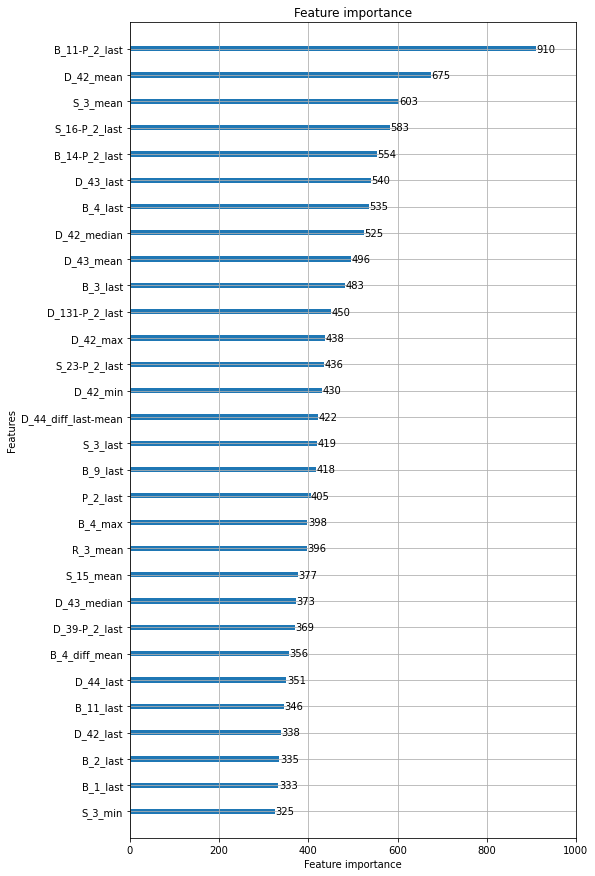

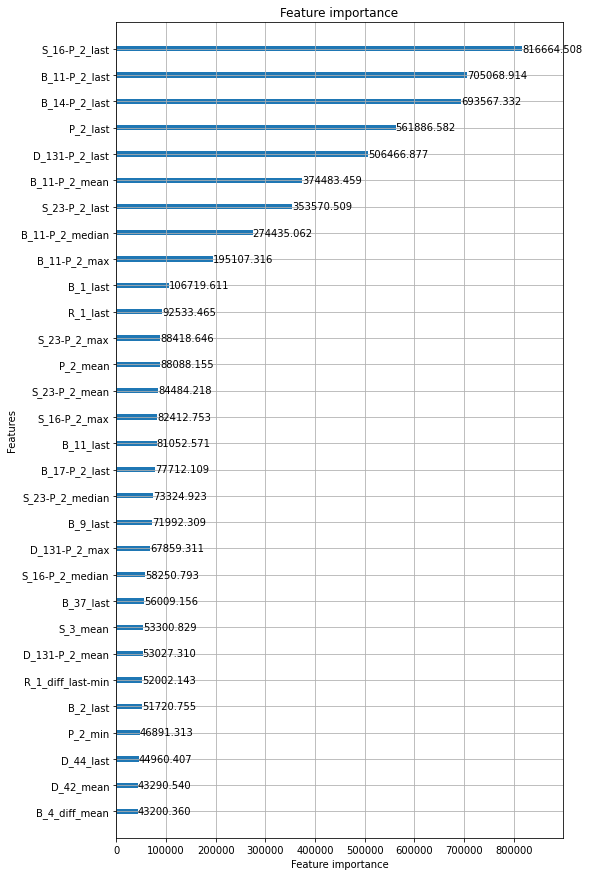

Training time: 217.14326454798382 min.
OOF recall_at4: 0.6692109603797085
OOF normalized_gini: 0.9258078747357241
OOF competition metric: 0.7975094175577163


CPU times: user 3d 10h 35min 37s, sys: 1min 56s, total: 3d 10h 37min 34s
Wall time: 10h 51min 27s


In [11]:
%%time 

all_scalers = list()
all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    scalers,models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_scalers.append(scalers)
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"model-cv{repetition}-fold{fold}.txt")
    for fold,_scaler in enumerate(scalers):
        joblib.dump(_scaler, ART_PATH/f"scaler-cv{repetition}-fold{fold}.pkl")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.669926,0.925851,0.797888
1,0.670221,0.925824,0.798022
2,0.669211,0.925808,0.797509



mean:


recall_at4    0.669786
gini          0.925827
metric        0.797807
dtype: float64


std:


recall_at4    0.000519
gini          0.000022
metric        0.000266
dtype: float64

In [13]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(
        dataframe:pd.DataFrame, 
        input_feats:list,
        numeric_feats:list,
        scalers:list,
        models:list,
    ) -> np.array:
    preds = list()
    for scaler,model in zip(scalers,models):
        _dataframe = dataframe.copy()
        _dataframe[numeric_feats] = scaler.transform(_dataframe[numeric_feats])
        preds.append( model.predict(_dataframe[input_feats]) )
    return np.mean(preds, axis=0)     

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    scalers = all_scalers[repetition]
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, numeric_feats, scalers, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

In [ ]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

***